# Home Credit Prediction: Model for all Tables combined


For an up-to-date version / full view of the plotly - plots, please, go to

Model on Applications table only: https://drive.google.com/file/d/17FsG6U-pZuVAhapyLvpVZ0RxtmDRb-vb/view?usp=sharing

List of all notebooks and resources for this project: https://drive.google.com/file/d/1Z8vPNZAcivWOxeh3UKFfeARbQCMkQ_NR/view?usp=sharing

Google Cloud deployment:

> curl -X 'POST' \
  'https://payment-issue-all-tables-xrnowswa4a-oe.a.run.app/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "AMT_ANNUITY_CREDIT_ratio": 0.044281,
  "AMT_ANNUITY_CREDIT_ratio_prev": 0.1317,
  "AMT_CREDIT_DEBT_LIMIT_RATIO": 0,
  "AMT_GOODS_PRICE": 472500.0,
  "AMT_GOODS_PRICE_CREDIT_ratio_prev": 1.020158,
  "DAYS_FIRST_DUE": -1805.8,
  "DAYS_LAST_DUE_1ST_VERSION": 71782,
  "EXT_SOURCE_1": 0,
  "EXT_SOURCE_2": 0.687929,
  "EXT_SOURCE_3": 0.524496,
  "HOUR_APPR_PROCESS_START_prev": 13.75,
  "SELLERPLACE_AREA": 102.917,
  "TERM_ACTUAL_months": 10.6,
  "int_rate": 1.245642,
  "int_rate_plain": 0.23047,
  "int_rate_plain_diff": 0
}'

Case: Applicant has previous contracts listed in each sub-table (POS, credit card, bureau)

In this step, I will predict the payment ability of a Home Credit's client based on maximum of information that could be available.
This implies that each clients has information in each of the tables on the clients' credit/payment history.



## Imports

In [ ]:
%%capture
#! pip install -q fastparquet
#! pip install -q xgboost
! pip install -q scikit-optimize
! pip install -q eli5
! pip install -q shap
! pip install -q sklego
! pip install scikit-learn==1.2.2 # need old version for eli5
! pip install xgboost==2.0.2

#! pip install -q onnxruntime
#! pip install -q skl2onnx

In [ ]:
import numpy as np
import pandas as pd

import sys
import os
import warnings

from dask import dataframe as dd
import matplotlib.pyplot as plt
#import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                   LabelEncoder)

#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer, KNNImputer

#from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import (RepeatedKFold,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold)
#from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

#from sklearn.metrics import confusion_matrix #for confusion matrix
#from sklearn.metrics import accuracy_score, f1_score
from skopt.space import Real, Categorical, Integer
#from scipy.stats import randint, loguniform, uniform

import copy

#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.experimental import enable_halving_search_cv # noqa
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

import eli5
from eli5.sklearn import PermutationImportance
import shap
#from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.classifier import (ROCAUC,
                                    PrecisionRecallCurve,
                                    DiscriminationThreshold)

from sklego.meta import Thresholder


import pickle


# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=False)


from google.colab import drive
drive.mount("/content/gdrive")

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#pd.reset_option('display.max_rows')

Mounted at /content/gdrive


In [ ]:
home_folder = '/content/gdrive/MyDrive/Colab Notebooks/Portfolio/ML_HomeCredit_DefaultRiskEvaluation/'

### Functions

The Python-file with the functions is at
https://drive.google.com/file/d/1IsRcGuolR4Hnu6bGe44GcS_0UQPFM59h/view?usp=sharing

In [ ]:
%load_ext autoreload
%autoreload 2

sys.path.append(home_folder)
import driskfunc as dfunc

In [ ]:
! pip freeze > /content/gdrive/MyDrive/Colab\ Notebooks/Portfolio/ML_HomeCredit_DefaultRiskEvaluation/requirements.txt

# Model - Payment Issues

### Cross Validations and Score Metric Definitions

In [ ]:
#cvRK = RepeatedKFold(n_splits=5, n_repeats= 10, random_state=1)
cvSK = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
#cvSKs = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cvRSK = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

Most useful score based on experience from previous projects:

In [ ]:
#scoring = 'r2' #'f1'
scoring = 'balanced_accuracy' #'f1_weighted'
#scoring = 'f1_macro'
#scoring = 'f1_weighted'
#scoring = 'roc_auc'  #crashes at RFECV

### Estimators

If computation time allows I am curious about the performances of as many classifiers as possible. Therefore I hold a collection of them ready to use.

DEFINE HERE THE SET OF CLASSIFIERS TO BE USED in this run:

In [ ]:
classifiers=[#'Linear Svm','Radial Svm',
             'Logistic Regression',
             'KNN',
             'Decision Tree', #'Random Forest',
             'LightGBM', 'XGBoost'] #, 'CatBoost']

Base Classifier Setup

In [ ]:
%reload_ext autoreload

# probability=True in SVMs needed for later scoring, but
# LinSVC = LinearSVC(random_state = 1, class_weight="balanced")
#  <-- cannot set probability=True for later scoring - replace by kernel SVC
LinSVC = SVC(kernel='linear', random_state = 1, class_weight="balanced",
             probability=True)
rbfSVC = SVC(kernel='rbf', random_state = 1, class_weight="balanced",
             probability=True)


#RandomizedSearch takes too long with probability=True
#--> create extra version for hypertuning
LinSVC_hypersearch = SVC(kernel='linear', random_state = 1, class_weight="balanced")
rbfSVC_hypersearch = SVC(kernel='rbf', random_state = 1, class_weight="balanced")

LogReg = LogisticRegression(random_state = 1, n_jobs=-1,
                            class_weight="balanced")
KNNClas = KNeighborsClassifier(n_jobs=-1)
DTClas = DecisionTreeClassifier(random_state = 1,
                                class_weight="balanced")
RFClas = RandomForestClassifier(random_state = 1, n_jobs=-1,
                                class_weight="balanced", )
LGBMClas = dfunc.LGBMClassifierWithEarlyStop(random_state=1,
                                             class_weight="balanced",
                                             objective="binary",
                                             metric="binary_logloss",
                                             early_stopping_round=10,
                                             verbosity=-100,
                                             force_row_wise=True,
                                             )

XGBClas = dfunc.XGBoostClassifierWithEarlyStop(random_state=1,
                                               enable_categorical=False,
                                               eval_metric='binary_logloss',
                                               verbosity=0)

# estimators and their names
classifier_map = {'Linear Svm': LinSVC,
                  'Radial Svm': rbfSVC,
                  'Logistic Regression': LogReg,
                  'KNN': KNNClas,
                  'Decision Tree': DTClas,
                  'Random Forest': RFClas,
                  'LightGBM': LGBMClas,
                  'XGBoost': XGBClas
}

### Load Data - All Tables Combined

In [ ]:
%%capture
#! mkdir home_folder+'cleaned/'
df_final = dd.read_csv(home_folder+'cleaned/HC_app_train_combined.csv')

In [ ]:
size_df_final = [df_final.shape[0].compute(),  df_final.shape[1]]

print('The combined dataset has', size_df_final[0], 'rows and', size_df_final[1], 'features.')

The combined dataset has 307511 rows and 291 features.


Let's only take rows the have entries in every table:

In [ ]:
# flag_table_install
# flag_table_pos_cash
# flag_table_credit_card
# flag_table_bureau

df_select = df_final.loc[(df_final.flag_table_pos_cash_sum>0) &
                         (df_final.flag_table_credit_card_sum>0) &
                         (df_final.flag_table_bureau>0)]

In [ ]:
size_df_select = [df_select.shape[0].compute(),  df_select.shape[1]]

print('The selected dataset has', size_df_select[0], 'rows and', size_df_select[1], 'features.')

The selected dataset has 65001 rows and 291 features.


In [ ]:
nan_overview_df = dfunc.nan_type_overview_dd(df_select, size_df_select[0])
nan_overview_df.round(1).style.background_gradient(cmap="Blues")

,type,NaN[abs],NaN[%]
SK_ID_CURR,int64,0,0.000000
TARGET,int64,0,0.000000
NAME_CONTRACT_TYPE,string,0,0.000000
CODE_GENDER,float64,0,0.000000
FLAG_OWN_CAR,int64,0,0.000000
FLAG_OWN_REALTY,int64,0,0.000000
CNT_CHILDREN,int64,0,0.000000
AMT_INCOME_TOTAL,float64,0,0.000000
AMT_CREDIT,float64,0,0.000000
AMT_ANNUITY,float64,7,0.000000


##### Sample

In [ ]:
SAMPLES = 10000
frac = SAMPLES/size_df_select[0]

if frac > 1:
    data = df_select.compute()
else:
    data = df_select.sample(frac=frac, replace=False, random_state=10).compute()

### Test Train Split

Select features to use and split data:

In [ ]:
RFECV_LightGBM_all_tables = [
'SELLERPLACE_AREA',
'AMT_ANNUITY_CREDIT_ratio_prev',
'int_rate_plain_diff',
'int_rate_plain',
'DAYS_LAST_DUE_1ST_VERSION',
'DAYS_FIRST_DUE',
'EXT_SOURCE_1',
'EXT_SOURCE_2',
'EXT_SOURCE_3',
'AMT_GOODS_PRICE',
'HOUR_APPR_PROCESS_START_prev',
'TERM_ACTUAL_months',
'AMT_ANNUITY_CREDIT_ratio',
'int_rate',
'AMT_CREDIT_DEBT_LIMIT_RATIO',
'AMT_GOODS_PRICE_CREDIT_ratio_prev']

In [ ]:
features = RFECV_LightGBM_all_tables

X = data[features]
to_drop = ['TARGET', 'SK_ID_CURR']

for item in to_drop:
    if item in X.columns:
        X = X.drop(columns=item)

y = data['TARGET'].to_frame()

In [ ]:
nan_overview_df = dfunc.nan_type_overview(X)
nan_overview_df.round(1).style.background_gradient(cmap="Blues")

,Nan?,#Nan,type
SELLERPLACE_AREA,False,0,float64
AMT_ANNUITY_CREDIT_ratio_prev,False,0,float64
int_rate_plain_diff,True,9860,float64
int_rate_plain,False,0,float64
DAYS_LAST_DUE_1ST_VERSION,True,5,float64
DAYS_FIRST_DUE,True,5,float64
EXT_SOURCE_1,True,5320,float64
EXT_SOURCE_2,True,1,float64
EXT_SOURCE_3,True,646,float64
AMT_GOODS_PRICE,True,1,float64


In [ ]:
y['TARGET'].value_counts()/len(data)

,count
TARGET,
0,0.913
1,0.087


In [ ]:
LE = LabelEncoder()
y = LE.fit_transform(y)

#labels = LE.classes_.tolist()
labels = ['No\nPayment\nIssues', 'Payment\nIssues']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    stratify = y) # <---- no stratify for cont. var!!!!!

### Preprocessor Setup

**Setup of the Ordinal Encoder**

In [ ]:
ordinal_encode = {}

ord_stepname_pre = "ord_"

ordinal_impute_step = ("imputer", KNNImputer(n_neighbors=3))
ordinal_transformers=[]

for key in ordinal_encode.keys():
    ordinal_step = ('ordenc', OrdinalEncoder(handle_unknown="error",
                    categories = [ordinal_encode[key]]))
    ordinal_transformer = Pipeline(steps = [ordinal_impute_step,
                                            ordinal_step])
    ordinal_transformer_key = (ord_stepname_pre + key, ordinal_transformer, [key])
    ordinal_transformers.append(ordinal_transformer_key)

In [ ]:
#### switch this here on and off for the use of ordinal encoding:
#ordinal_encode={}

**Setup of the Numerical and Categorical Transformers**

In [ ]:
numeric_transformer_scaled = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=3)),
           ("scaler", StandardScaler())
           ]
)

numeric_transformer_tree = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=3)),
           ]
)

categorical_transformer = Pipeline(
    steps=[
           ("encoder", OneHotEncoder(handle_unknown="ignore")),
           ]
)

**Define the ColumnTransformer preprocessing Pipeline and gather the new Columns Names**

In [ ]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feat = X_train.select_dtypes(exclude=np.number).columns.tolist()
ord_feat = ordinal_encode.keys()

# if ordinal, remove ordinal features from categorical feature list
if ordinal_encode:
    for feat in ord_feat:
        if feat in cat_feat:
            cat_feat.remove(feat)

# basic transformer
transformers_scaled=[("num", numeric_transformer_scaled, num_feat),
              ("cat", categorical_transformer, cat_feat)
              ]

transformers_tree=[("num", numeric_transformer_tree, num_feat),
              ("cat", categorical_transformer, cat_feat)
              ]

# if ordinal, extend basic transformer
if ordinal_encode:
    transformers_scaled.extend(ordinal_transformers)
    transformers_tree.extend(ordinal_transformers)


# THE PREPROCESSOR
preprocessor_scaled = ColumnTransformer(transformers=transformers_scaled,
                                 remainder='passthrough',
                                 # suppress sparse matrix output:
                                 # happend here for case of categoricals only
                                 sparse_threshold=0
                                 )

preprocessor_tree = ColumnTransformer(transformers=transformers_tree,
                                 remainder='passthrough',
                                 # suppress sparse matrix output:
                                 # happend here for case of categoricals only
                                 sparse_threshold=0
                                 )

# restoring the columns names after transform:
X_train_transformed = preprocessor_scaled.fit_transform(X_train)

new_cols = preprocessor_scaled.get_feature_names_out().tolist()

# rename ordinal
for key in ordinal_encode.keys():
   list_index = new_cols.index(ord_stepname_pre+key+"__"+key)
   new_cols[list_index] = ord_stepname_pre+"_"+key

# test if restoring worked (fails for inconsistent shape/length)
X_train_prep = pd.DataFrame(X_train_transformed, columns=new_cols)

Turn proprocessor into general pipeline steps to which the next steps can be appended, e.g. over/undersampling, classifier.


In [ ]:
X_transformer_steps_scaled = [('preprocessor', preprocessor_scaled)]
X_transformer_steps_tree = [('preprocessor', preprocessor_tree)]

# general pipeline preprocessing steps, i.e. append over/undersampling
pipe_prep_steps = X_transformer_steps_scaled.copy()
pipe_prep_steps_tree = X_transformer_steps_tree.copy()

In [ ]:
print('The number of features increased from', len(X_train.columns), 'to',
      len(X_train_prep.columns), 'after preprocessing.' )
#len(X_train.columns), len(X_train_prep.columns)

The number of features increased from 16 to 16 after preprocessing.


In [ ]:
# how to access infos:
# preprocessor.transformers[0][2]

### Scores of a DummyEstimator as Baseline

First, we do a crossvalidation on the a dummy estimator to obtain a baseline.

In [ ]:
%%time
%reload_ext autoreload

dummy_name = ['dummy']
dummy = [DummyClassifier(strategy="most_frequent")]

estimators_dummy = dummy

models_dummy=[]
for estimator in estimators_dummy:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('classifier' , estimator))
    models_dummy.append(Pipeline(pipe_steps))

model_cv_results_dummy = dfunc.model_scores(X_train,y_train,X_test,
                                      models = models_dummy,
                                      model_names = dummy_name,
                                      cv = cvRSK)

(model_performance_dummy,
 collect_cv_results_dummy,
 model_prob_dummy) = model_cv_results_dummy

Executing dummy
Done!
CPU times: user 4min 15s, sys: 1min 19s, total: 5min 35s
Wall time: 4min 52s


Crossvalidation test (mean of the k-folds) scores:

In [ ]:
model_performance_dummy.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
dummy,0.913,0.0,0.5,0.0,0.0,0.0,0.913,0.0,0.477,0.0,0.871,0.0,0.0,0.0,0.913,0.0,0.456,0.0,0.834,0.0,0.087,0.0,0.0,0.0,0.913,0.0,0.5,0.0,0.913,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.0


Reminder:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

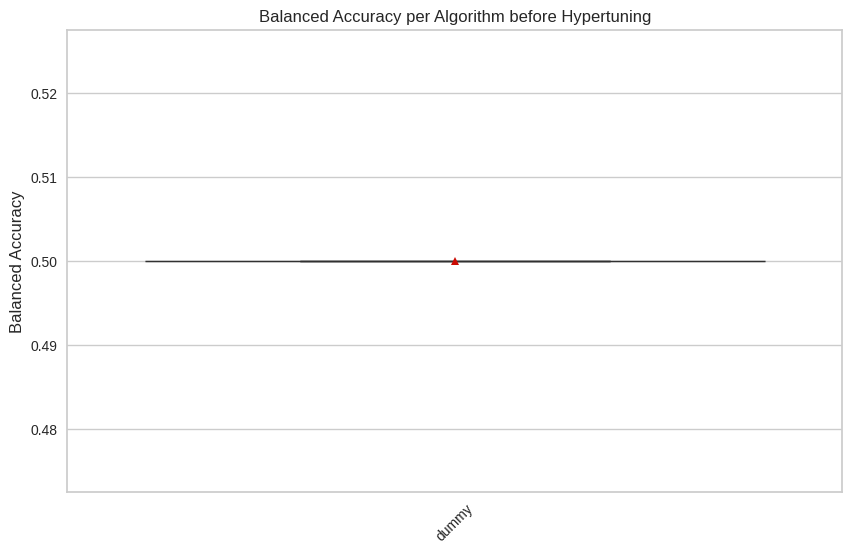

In [ ]:
score_metric = scoring
dfunc.plot_model_score([collect_cv_results_dummy],
                 score = score_metric, classifiers_names = dummy_name,
                 colors = ['skyblue'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before Hypertuning')  ;

#### Confusion Matrices before Hypertune

''

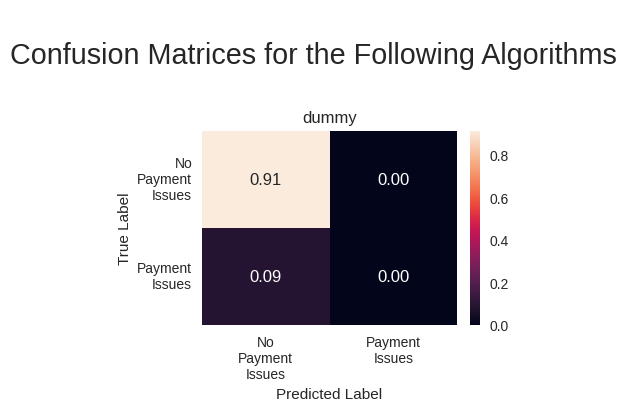

In [ ]:
%reload_ext autoreload

dfunc.plot_confusion_matrices(model_prob_dummy,y_test,
                              names = dummy_name,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following Algorithms')
;

### Scores per Basic Model BEFORE Hyperparameter Tuning

Now, we do a crossvalidation on the estimators selected at the beginning with their default parameters to see where we stand.

In [ ]:
%%time
%reload_ext autoreload

estimators_basic = []
for clas in classifiers:
    estimators_basic.append(classifier_map[clas])

models_basic=[]
for estimator in estimators_basic:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('classifier' , estimator))
    models_basic.append(Pipeline(pipe_steps))

model_cv_results_before = dfunc.model_scores(X_train,y_train,X_test,
                                      models = models_basic,
                                      model_names = classifiers,
                                      cv = cvRSK)

(model_performance_before,
 collect_cv_results_before,
 model_prob_before) = model_cv_results_before

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[3]	validation_0-logloss:0.32189
[4]	validation_0-logloss:0.31913
[5]	validation_0-logloss:0.32107
[6]	validation_0-logloss:0.32191
[7]	validation_0-logloss:0.32288
[8]	validation_0-logloss:0.32516
[9]	validation_0-logloss:0.32475
[10]	validation_0-logloss:0.32413
[11]	validation_0-logloss:0.33085
[12]	validation_0-logloss:0.33287
[13]	validation_0-logloss:0.33222
[14]	validation_0-logloss:0.33514
[15]	validation_0-logloss:0.33684
[16]	validation_0-logloss:0.33677
[17]	validation_0-logloss:0.33495
[18]	validation_0-logloss:0.33630
[19]	validation_0-logloss:0.33729
[20]	validation_0-logloss:0.33857
[21]	validation_0-logloss:0.33860
[22]	validation_0-logloss:0.33850
[23]	validation_0-logloss:0.34015
[24]	validation_0-logloss:0.34101
[25]	validation_0-logloss:0.34295
[26]	validation_0-logloss:0.34516
[27]	validation_0-logloss:0.34463
[28]	validation_0-logloss:0.34601
[29]	validation_0-logloss:0.34837
[30]	validation_0-logl

Crossvalidation test (mean of the k-folds) scores:

In [ ]:
model_performance_before.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
Logistic Regression,0.684,0.010,0.678,0.021,0.270,0.015,0.684,0.010,0.534,0.010,0.753,0.008,0.169,0.009,0.684,0.010,0.563,0.007,0.888,0.006,0.223,0.020,0.670,0.043,0.684,0.010,0.678,0.021,0.684,0.010,0.731,0.020,0.731,0.020,0.731,0.020,0.731,0.020,0.731,0.020
KNN,0.904,0.003,0.508,0.007,0.049,0.022,0.904,0.003,0.499,0.011,0.871,0.003,0.183,0.087,0.904,0.003,0.549,0.044,0.851,0.009,0.115,0.008,0.028,0.013,0.904,0.003,0.508,0.007,0.904,0.003,0.587,0.019,0.587,0.019,0.587,0.019,0.587,0.019,0.587,0.019
Decision Tree,0.850,0.009,0.535,0.015,0.152,0.027,0.850,0.009,0.535,0.015,0.851,0.006,0.150,0.029,0.850,0.009,0.535,0.016,0.852,0.005,0.097,0.007,0.154,0.028,0.850,0.009,0.535,0.015,0.850,0.009,0.535,0.015,0.535,0.015,0.535,0.015,0.535,0.015,0.535,0.015
LightGBM,0.853,0.007,0.583,0.016,0.232,0.026,0.853,0.007,0.575,0.014,0.859,0.005,0.213,0.024,0.853,0.007,0.571,0.013,0.866,0.005,0.184,0.020,0.255,0.034,0.853,0.007,0.583,0.016,0.853,0.007,0.689,0.021,0.689,0.021,0.689,0.021,0.689,0.021,0.689,0.021
XGBoost,0.907,0.002,0.513,0.008,0.064,0.027,0.907,0.002,0.507,0.014,0.874,0.003,0.252,0.093,0.907,0.002,0.583,0.047,0.857,0.009,0.169,0.015,0.037,0.016,0.907,0.002,0.513,0.008,0.907,0.002,0.667,0.022,0.667,0.022,0.667,0.022,0.667,0.022,0.667,0.022


Reminder:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

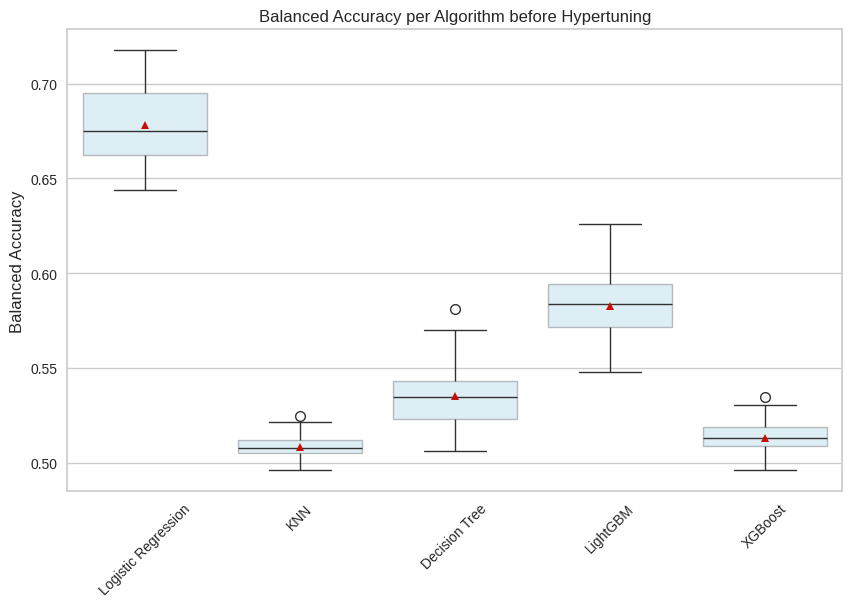

In [ ]:
score_metric = scoring
dfunc.plot_model_score([collect_cv_results_before],
                 score = score_metric, classifiers_names = classifiers,
                 colors = ['skyblue'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before Hypertuning')  ;

#### Confusion Matrices before Hypertune

''

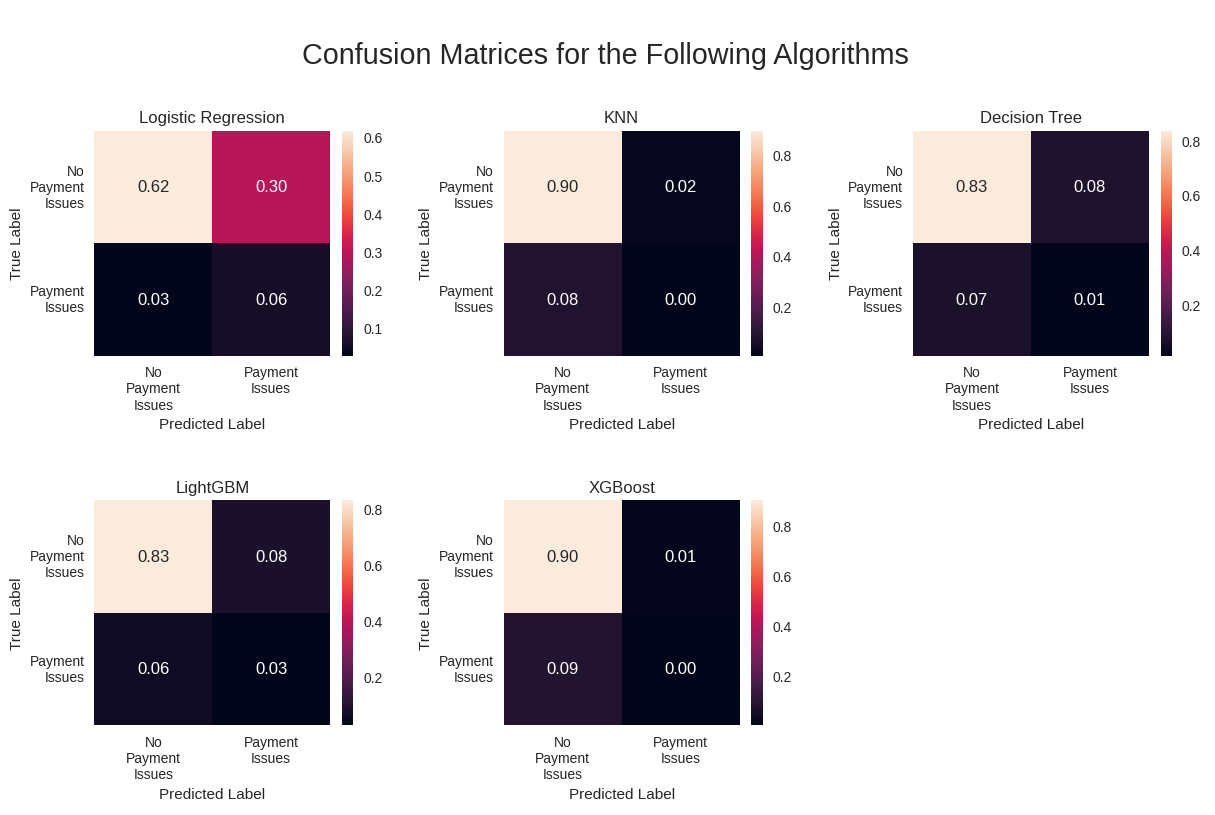

In [ ]:
%reload_ext autoreload

dfunc.plot_confusion_matrices(model_prob_before,y_test,
                              names = classifiers,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following Algorithms')
;

## Hyperparameter Tuning with BayesSearchCV

In [ ]:
classifiers_h = classifiers

In a previous project, I have made the function 'hyper_search' to loop over the given estimators and several (grid-)search-varieties ('Grid', 'HalvingGrid', 'Random', 'HalvingRandom').
Meanwhile, I have implemented BayesSearchCV, which yields higher scores than Randomized Search, that was best in the previous projects.

The placeholder estimator in the pipeline will be replaced by the classifiers in the hyperparameter dictionaries

In [ ]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('classifier' , RandomForestClassifier()))

pipe = Pipeline(pipe_steps, memory=memory)   # cache pipeline results except from last step

In the following, I create the parameter distribution for BayesSearchCV per classifier. Since XGBoost and LightGBM are fast, I let them test more parameters.

In [ ]:
%reload_ext autoreload

# Create param distribution (BayesSearchCV) per classifier

hyper_bayes_XGB = {'preprocessor': Categorical([preprocessor_tree]),
          'classifier' : Categorical([XGBClas]),
          "classifier__n_estimators": Integer(50, 1000),
          "classifier__max_depth": Integer(1, 10),
          "classifier__scale_pos_weight": Real(1, 30),
          "classifier__learning_rate": Real(0.05, 0.2),
          'classifier__early_stopping_rounds': Integer(5, 10),
          "classifier__min_child_weight": Integer(1, 12),       # min. number of obs. (hessians) in a node to make split
          "classifier__gamma": Real(0, 1),                   # L0 regularization - dep. on number of leaves
          "classifier__reg_alpha": Real(0, 1),               # L1 regularization
          "classifier__reg_lambda": Real(0, 1),              # L2 regularization
          "classifier__subsample": Real(0.1, 1),
          "classifier__colsample_bytree": Real(0.1, 1),

      }


hyper_bayes_LightGBM = {'preprocessor': Categorical([preprocessor_tree]),
        'classifier' : Categorical([LGBMClas]),
        "classifier__n_estimators": Integer(50, 1000),
        "classifier__max_depth": Integer(1, 12),
        "classifier__boosting_type": Categorical(["gbdt"]),
        "classifier__learning_rate": Real(0.05, 0.2),
        "classifier__lambda_l1": Real(1e-8, 10.0, prior='log-uniform'),
        "classifier__lambda_l2": Real(1e-8, 10.0, prior='log-uniform'),
        "classifier__num_leaves": Integer(2, 256),
        'classifier__early_stopping_round': Integer(1, 10),
        "classifier__feature_fraction": Real(0.4, 1.0),
        "classifier__bagging_fraction": Real(0.4, 1.0),
        "classifier__bagging_freq": Integer(1, 7),
        "classifier__min_child_samples": Integer(5, 100),
        }

hyper_bayes_LinSVC = {
     'classifier' : Categorical([LinSVC_hypersearch]),
     'classifier__C' : Real(0.01, 1e3, prior='log-uniform')}

hyper_bayes_rbfSVC = {
     'classifier' : Categorical([rbfSVC_hypersearch]),
     'classifier__kernel' : Categorical(['rbf']),
     'classifier__C' : Real(0.01, 1e3, prior='log-uniform'),
     'classifier__gamma': Real(0.01, 1e3, prior='log-uniform')}

hyper_bayes_LogReg = {'classifier' : Categorical([LogReg]),
     'classifier__C' : Real(0.01, 1e3, prior='log-uniform')}

hyper_bayes_KNN = {'classifier' : Categorical([KNNClas]),
             'classifier__n_neighbors' : Integer(1, 21),
             'classifier__weights' : Categorical(['uniform','distance']),
             'classifier__metric' : Categorical(['minkowski','euclidean','manhattan'])}

#https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
hyper_bayes_DTC = {'preprocessor': Categorical([preprocessor_tree]),
     'classifier' : Categorical([DTClas]),
     'classifier__min_samples_split' : Integer(10, 41),
     'classifier__min_samples_leaf' : Integer(1, 21)}

hyper_bayes_RFC = {'preprocessor': Categorical([preprocessor_tree]),
     'classifier' : Categorical([RFClas]),
     'classifier__n_estimators' : Integer(10, 1000),
     #'classifier__max_features': Categorical(['sqrt', 'log2', None]),
     #'classifier__max_depth': Integer(1, 10),
     #'classifier__max_leaf_nodes': Integer(1, 10)
                    }


# Classifiers and their corresponding hyperparameter setup
param_bayes_map = {'Linear Svm': hyper_bayes_LinSVC,
                  'Radial Svm': hyper_bayes_rbfSVC,
                  'Logistic Regression': hyper_bayes_LogReg,
                  'KNN': hyper_bayes_KNN,
                  'Decision Tree': hyper_bayes_DTC,
                  'Random Forest': hyper_bayes_RFC,
                  'LightGBM': hyper_bayes_LightGBM,
                  'XGBoost': hyper_bayes_XGB
}

# hyperparameter setups used in this run:
param_distro_bayes = []
for clas in classifiers_h:
    param_distro_bayes.append(param_bayes_map[clas])

### on Balanced Accuracy

After several tests on different tuning scores, 'balanced_accuracy' gave the most convincing, i.e. 'balanced' results.  

In [ ]:
ht_scoring = 'balanced_accuracy'

#### Hyperparameter Tuning

In [ ]:
%%time
%reload_ext autoreload

start = 0
stop = 4

hyper_params = dfunc.hyper_search(pipe,  X_train, y_train,
                            param_bayes = param_distro_bayes, #[start:stop],
                            classifier_names = classifiers,#[start:stop],
                            cv = cvSK, niter = 20,
                            searches = ['Bayes'],
                            scoring = ht_scoring,
                            random_state = 3,
                            verbose=0)

Executing Logistic Regression
for search method: Bayes
best score: 0.681
best parameters: OrderedDict([('classifier', LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=1)), ('classifier__C', 0.0169909501075286)])
 
Executing KNN
for search method: Bayes
best score: 0.532
best parameters: OrderedDict([('classifier', KNeighborsClassifier(n_jobs=-1)), ('classifier__metric', 'minkowski'), ('classifier__n_neighbors', 2), ('classifier__weights', 'distance')])
 
Executing Decision Tree
for search method: Bayes
best score: 0.597
best parameters: OrderedDict([('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=1)), ('classifier__min_samples_leaf', 21), ('classifier__min_samples_split', 27), ('preprocessor', ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=3))]),
      

In [ ]:
hyper_params

,classifier,search method,best score,time[s],best params
0,Logistic Regression,Bayes,0.681,114.0,"{'classifier': LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=1), 'classifier__C': 0.0169909501075286}"
1,KNN,Bayes,0.532,119.1,"{'classifier': KNeighborsClassifier(n_jobs=-1), 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 2, 'classifier__weights': 'distance'}"
2,Decision Tree,Bayes,0.597,120.4,"{'classifier': DecisionTreeClassifier(class_weight='balanced', random_state=1), 'classifier__min_samples_leaf': 21, 'classifier__min_samples_split': 27, 'preprocessor': ColumnTransformer(remainder='passthrough', sparse_threshold=0, transformers=[('num', Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3))]), ['SELLERPLACE_AREA', 'AMT_ANNUITY_CREDIT_ratio_prev', 'int_rate_plain_diff', 'int_rate_plain', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DUE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START_prev', 'TERM_ACTUAL_months', 'AMT_ANNUITY_CREDIT_ratio', 'int_rate', 'AMT_CREDIT_DEBT_LIMIT_RATIO', 'AMT_GOODS_PRICE_CREDIT_ratio_prev']), ('cat', Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), [])])}"
3,LightGBM,Bayes,0.672,126.8,"{'classifier': LGBMClassifierWithEarlyStop(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0, early_stopping_round=10, force_row_wise=True, importance_type='split', learning_rate=0.1, max_depth=-1, metric='binary_logloss', min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=None, num_leaves=31, objective='binary', random_state=1, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0, subsample_for_bin=200000, subsample_freq=0, verbosity=-100), 'classifier__bagging_fraction': 0.605328737965311, 'classifier__bagging_freq': 2, 'classifier__boosting_type': 'gbdt', 'classifier__early_stopping_round': 7, 'classifier__feature_fraction': 0.7811240859877939, 'classifier__lambda_l1': 5.915978868043068e-06, 'classifier__lambda_l2': 1e-08, 'classifier__learning_rate': 0.05798204418542291, 'classifier__max_depth': 4, 'classifier__min_child_samples': 100, 'classifier__n_estimators': 50, 'classifier__num_leaves': 38, 'preprocessor': ColumnTransformer(remainder='passthrough', sparse_threshold=0, transformers=[('num', Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3))]), ['SELLERPLACE_AREA', 'AMT_ANNUITY_CREDIT_ratio_prev', 'int_rate_plain_diff', 'int_rate_plain', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DUE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START_prev', 'TERM_ACTUAL_months', 'AMT_ANNUITY_CREDIT_ratio', 'int_rate', 'AMT_CREDIT_DEBT_LIMIT_RATIO', 'AMT_GOODS_PRICE_CREDIT_ratio_prev']), ('cat', Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]), [])])}"
4,XGBoost,Bayes,0.663,132.9,"{'classifier': XGBoostClassifierWithEarlyStop(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, objective='binary:logistic', ...), 'classifier__colsample_bytree': 0.8110193209049552, 'classifier__early_stopping_rounds': 5, 'classifier__gamma': 0.7536051257002312, 'classifier__learning_rate': 0.10596794069833823, 'classifier__max_depth': 1, 'classifier__min_child_weight': 11, 'classifier__n_estimators': 988, 'classifier__reg_alpha': 0.2009137865530124, 'classifier__reg_lambda': 0.35356530947303283, 'classifier__scale_pos_weight': 13.750700590527604, 'classifier__subsample': 1.0, 'preprocessor': ColumnTransformer(remai

Extract the best tuned hyperparameters per classifier:

In [ ]:
param_classifiers={}


for classifier in classifiers_h:
    param_classifier = hyper_params.loc[(hyper_params['classifier']==classifier)]
    param_classifier = param_classifier.loc[param_classifier['best score']==param_classifier['best score'].max()]['best params'].values[0]
    # replace the 'classifier__' in the keys --> can insert best params directly into untuned classifiers
    if 'preprocessor' in param_classifier.keys():
        param_classifier.pop('preprocessor')
    if 'classifier' in param_classifier.keys():
        param_classifier.pop('classifier')
    new_keys = [key.replace('classifier__','') for key in param_classifier.keys()]
    param_classifier = dict(zip(new_keys, list(param_classifier.values())))
    print(param_classifier)
    param_classifiers[classifier] = param_classifier

{'C': 0.0169909501075286}
{'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
{'min_samples_leaf': 21, 'min_samples_split': 27}
{'bagging_fraction': 0.605328737965311, 'bagging_freq': 2, 'boosting_type': 'gbdt', 'early_stopping_round': 7, 'feature_fraction': 0.7811240859877939, 'lambda_l1': 5.915978868043068e-06, 'lambda_l2': 1e-08, 'learning_rate': 0.05798204418542291, 'max_depth': 4, 'min_child_samples': 100, 'n_estimators': 50, 'num_leaves': 38}
{'colsample_bytree': 0.8110193209049552, 'early_stopping_rounds': 5, 'gamma': 0.7536051257002312, 'learning_rate': 0.10596794069833823, 'max_depth': 1, 'min_child_weight': 11, 'n_estimators': 988, 'reg_alpha': 0.2009137865530124, 'reg_lambda': 0.35356530947303283, 'scale_pos_weight': 13.750700590527604, 'subsample': 1.0}


##### Update the base classifiers with the hypertuned parameters:

In [ ]:
%%capture

LinSVC_h = copy.deepcopy(LinSVC_hypersearch)
if 'Linear Svm' in param_classifiers.keys():
    # probability=True in SVMs needed for later scoring:
    LinSVC_h.set_params(**param_classifiers['Linear Svm'], probability=True)

rbfSVC_h = copy.deepcopy(rbfSVC_hypersearch)
if 'Radial Svm' in param_classifiers.keys():
    rbfSVC_h.set_params(**param_classifiers['Radial Svm'], probability=True)

LogReg_h = copy.deepcopy(LogReg)
if 'Logistic Regression' in param_classifiers.keys():
    LogReg_h.set_params(**param_classifiers['Logistic Regression'])

KNNClas_h = copy.deepcopy(KNNClas)
if 'KNN' in param_classifiers.keys():
    KNNClas_h.set_params(**param_classifiers['KNN'])

DTClas_h = copy.deepcopy(DTClas)
if 'Decision Tree' in param_classifiers.keys():
    DTClas_h.set_params(**param_classifiers['Decision Tree'])

RFClas_h = copy.deepcopy(RFClas)
if 'Random Forest' in param_classifiers.keys():
    RFClas_h.set_params(**param_classifiers['Random Forest'])

LGBMClas_h = copy.deepcopy(LGBMClas)
if 'LightGBM' in param_classifiers.keys():
    LGBMClas_h.set_params(**param_classifiers['LightGBM'])

XGBClas_h = copy.deepcopy(XGBClas)
if 'XGBoost' in param_classifiers.keys():
    XGBoost_param_fit={}
    # cross_val_score cannot deal with 'early_stopping_rounds'
    # ---> put it into fit_params for the fit-function:
    if 'early_stopping_rounds' in param_classifiers['XGBoost']:
        XGBoost_param_fit['classifier__early_stopping_rounds'] = param_classifiers['XGBoost']['early_stopping_rounds']
        param_classifiers['XGBoost'].pop('early_stopping_rounds')
    XGBClas_h.set_params(**param_classifiers['XGBoost'])



# hypertuned estimators and their names
classifier_map_h = {'Linear Svm': LinSVC_h,
                  'Radial Svm': rbfSVC_h,
                  'Logistic Regression': LogReg_h,
                  'KNN': KNNClas_h,
                  'Decision Tree': DTClas_h,
                  'Random Forest': RFClas_h,
                  'LightGBM': LGBMClas_h,
                  'XGBoost': XGBClas_h
}

#### Scores per Basic Model AFTER Hyperparameter Tuning

Let's redo the crossvalidation on the algorithms with their now tuned parameters.

In [ ]:
models_hyped=[]
fit_params_hyped=[]

for clas in classifiers_h:
    estimator = classifier_map_h[clas]
    if clas in ['Linear Svm','Radial Svm', 'Logistic Regression', 'KNN']:
        pipe_steps = pipe_prep_steps.copy()
    else:
        pipe_steps = pipe_prep_steps_tree.copy()
    pipe_steps.append(('classifier' , estimator))
    models_hyped.append(Pipeline(pipe_steps))

    if estimator == XGBClas_h:
        fit_params_hyped.append(XGBoost_param_fit)
    else:
        fit_params_hyped.append(None)

In [ ]:
%%time
%reload_ext autoreload

model_cv_results_after = dfunc.model_scores(X_train,y_train,X_test,
                                      models = models_hyped,
                                      model_names = classifiers_h,
                                      fit_params = fit_params_hyped,
                                      cv = cvRSK)

(model_performance_after,
 collect_cv_results_after,
 model_prob_after) = model_cv_results_after

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[32]	validation_0-logloss:0.73194
[33]	validation_0-logloss:0.73006
[34]	validation_0-logloss:0.72946
[35]	validation_0-logloss:0.72912
[36]	validation_0-logloss:0.72793
[37]	validation_0-logloss:0.72649
[38]	validation_0-logloss:0.72602
[39]	validation_0-logloss:0.72589
[40]	validation_0-logloss:0.72412
[41]	validation_0-logloss:0.72351
[42]	validation_0-logloss:0.72242
[43]	validation_0-logloss:0.72168
[44]	validation_0-logloss:0.72047
[45]	validation_0-logloss:0.72013
[46]	validation_0-logloss:0.71984
[47]	validation_0-logloss:0.71931
[48]	validation_0-logloss:0.71778
[49]	validation_0-logloss:0.71623
[50]	validation_0-logloss:0.71553
[51]	validation_0-logloss:0.71446
[52]	validation_0-logloss:0.71449
[53]	validation_0-logloss:0.71369
[54]	validation_0-logloss:0.71340
[55]	validation_0-logloss:0.71250
[56]	validation_0-logloss:0.71167
[57]	validation_0-logloss:0.71039
[58]	validation_0-logloss:0.71015
[59]	validation

Crossvalidation test (mean of the k-folds) scores:

In [ ]:
model_performance_after.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
Logistic Regression,0.685,0.010,0.678,0.021,0.270,0.015,0.685,0.010,0.534,0.010,0.753,0.008,0.169,0.009,0.685,0.010,0.563,0.007,0.888,0.006,0.223,0.020,0.670,0.043,0.685,0.010,0.678,0.021,0.685,0.010,0.732,0.019,0.732,0.019,0.732,0.019,0.732,0.019,0.732,0.019
KNN,0.853,0.007,0.528,0.012,0.138,0.023,0.853,0.007,0.529,0.013,0.852,0.005,0.141,0.024,0.853,0.007,0.530,0.013,0.850,0.004,0.103,0.008,0.135,0.024,0.853,0.007,0.528,0.012,0.853,0.007,0.546,0.017,0.546,0.017,0.546,0.017,0.546,0.017,0.546,0.017
Decision Tree,0.684,0.013,0.587,0.022,0.205,0.018,0.684,0.013,0.504,0.011,0.751,0.009,0.131,0.011,0.684,0.013,0.532,0.008,0.863,0.006,0.133,0.015,0.469,0.047,0.684,0.013,0.587,0.022,0.684,0.013,0.614,0.022,0.614,0.022,0.614,0.022,0.614,0.022,0.614,0.022
LightGBM,0.728,0.011,0.664,0.022,0.272,0.018,0.728,0.011,0.552,0.011,0.784,0.008,0.177,0.011,0.728,0.011,0.563,0.008,0.882,0.006,0.218,0.021,0.586,0.048,0.728,0.011,0.664,0.022,0.728,0.011,0.724,0.020,0.724,0.020,0.724,0.020,0.724,0.020,0.724,0.020
XGBoost,0.597,0.018,0.662,0.018,0.242,0.011,0.597,0.018,0.484,0.011,0.684,0.015,0.145,0.006,0.597,0.018,0.552,0.006,0.889,0.006,0.219,0.021,0.740,0.044,0.597,0.018,0.662,0.018,0.597,0.018,0.723,0.021,0.723,0.021,0.723,0.021,0.723,0.021,0.723,0.021


Scores on Test Data:

In [ ]:
%reload_ext autoreload

model_performance_after_test = dfunc.get_test_scores_binary(y_test, model_prob_after, model_names = classifiers_h)
model_performance_after_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
Logistic Regression,0.680,0.269,0.167,0.684,0.748
KNN,0.558,0.191,0.182,0.201,0.590
Decision Tree,0.612,0.222,0.140,0.540,0.651
LightGBM,0.677,0.279,0.180,0.626,0.745
XGBoost,0.668,0.245,0.146,0.759,0.750


##### Score Plots

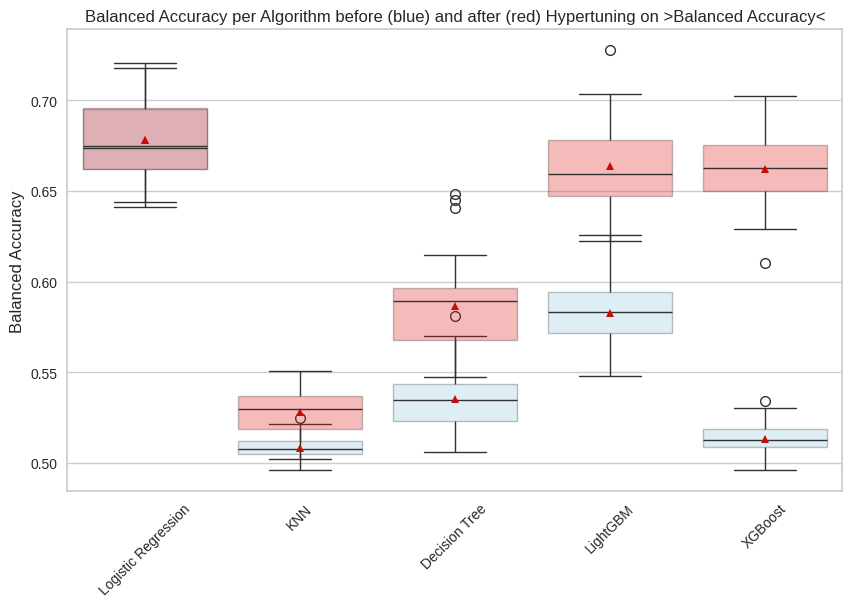

In [ ]:
score_metric = scoring
dfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = classifiers_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before (blue) '+
                        'and after (red) Hypertuning on >'+
                              ht_scoring.replace('_', ' ').title() +
                              '<')  ;

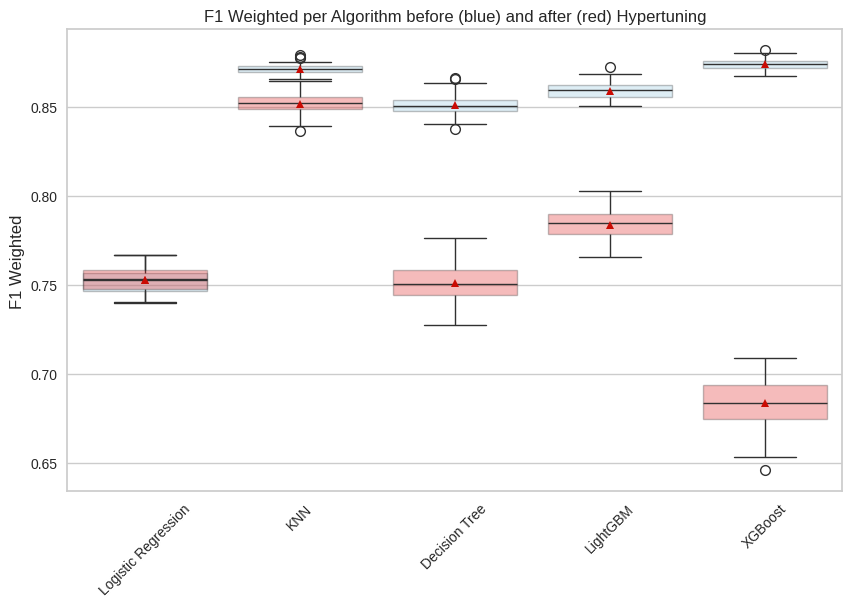

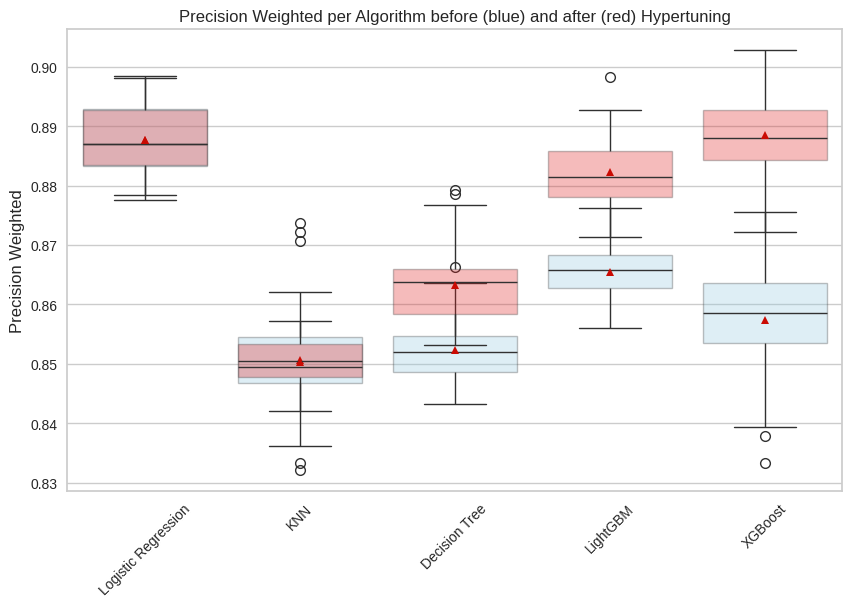

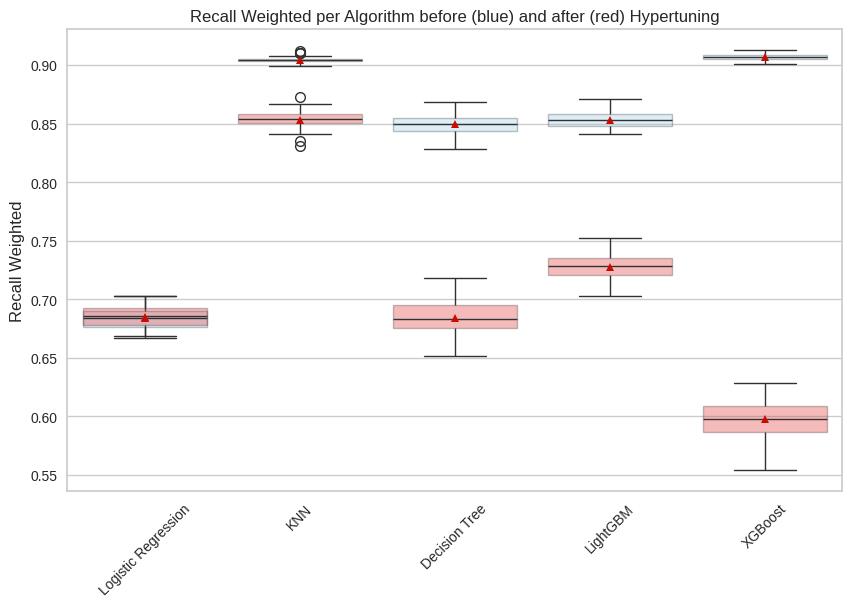

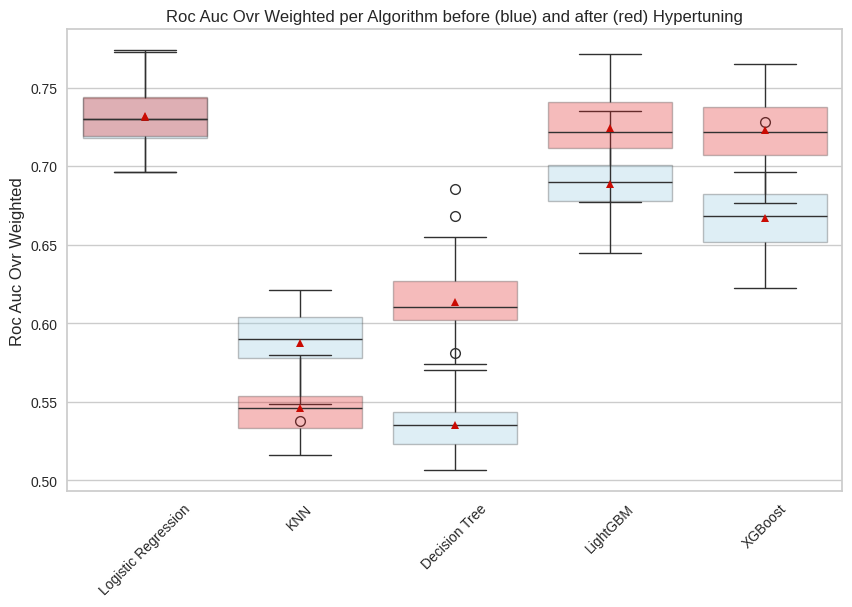

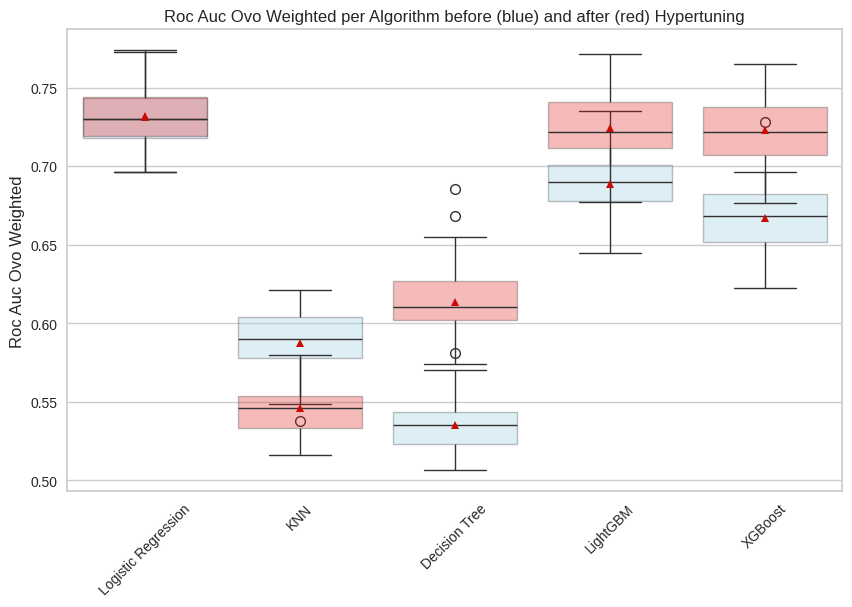

In [ ]:
score_metrics = ['balanced_accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted',
                 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted']

for score_metric in score_metrics:
    if score_metric is not scoring:
        dfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = classifiers_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before (blue) '+
                        'and after (red) Hypertuning')  ;

In [ ]:
#from sklearn.metrics import classification_report
#y_pred = (model_prob_after[-1][:, 1] > 0.5)#.astype("float")
#print(classification_report(y_test, y_pred))

##### Confusion Matrices after Hypertune

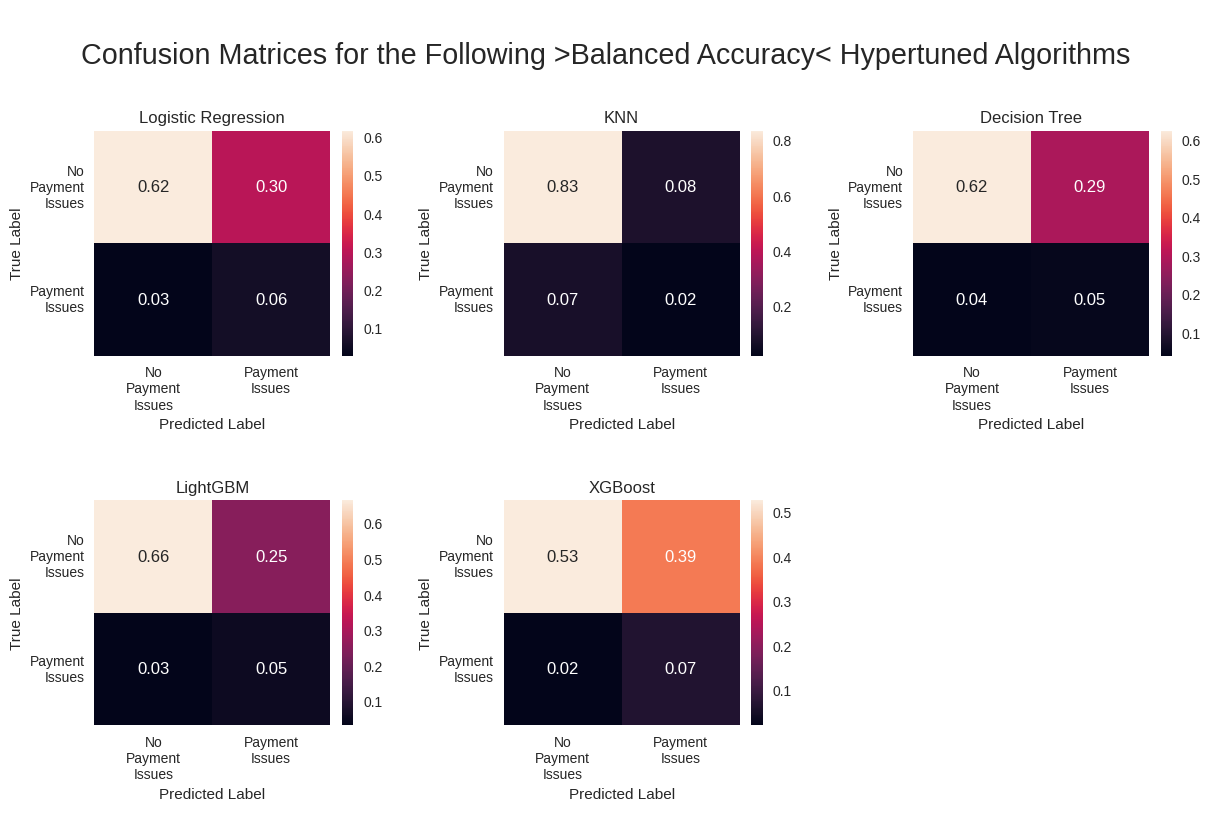

In [ ]:
%reload_ext autoreload


dfunc.plot_confusion_matrices(model_prob_after,y_test,
                              names = classifiers_h,
                              #threshold = 0.4,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following >'+
                              ht_scoring.replace('_', ' ').title() +
                              '< Hypertuned Algorithms')

#### Summary

* top priority: FP (predict 'no payment issue' despite payment issue) should be lowest in order to not lose as few loans as possible

* 2nd priority: FN (predict 'payment issue' despite no payment issue present) should drop, while TN should increase to increase the yield on interest and fees as more applications (true label = no payment issues) are accepted.

With these constrains the results from Logistic Regression and LightGBM look most promising --> continue with ensembling of them.

## Ensemble

### Voting Classifier

In [ ]:
%%time
%reload_ext autoreload

classifiers_vot = classifiers_h.copy()

to_exclude = ['Linear Svm','Radial Svm',
             #'Logistic Regression',
             'KNN',
             #'Decision Tree',
              'Random Forest',
             #'LightGBM',
              'XGBoost'
              ]
for item in to_exclude:
    if item in classifiers_vot:
        classifiers_vot.remove(item)

estimators_vot = []
for clas in classifiers_vot:
    estimators_vot.append(classifier_map_h[clas])

estimators_list = list(zip(classifiers_vot,estimators_vot))

# Need to remove XGBoost because it needs fit_params for early stopping
# - unclear how to implement this without crashing
if 'XGBoost' in classifiers_vot:
    index = classifiers_vot.index('XGBoost')
    estimators_list.pop(index)

vot_clas = VotingClassifier(estimators = estimators_list,
                            voting='soft')
vot_class_name = 'vot_classifiers'

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append((vot_class_name , vot_clas))

vot_pipe = Pipeline(pipe_steps)

vot_perf, vot_results, vot_prob = dfunc.model_scores(X_train,y_train,X_test,
                                                     models = [vot_pipe],
                                                     model_names = [vot_class_name],
                                                     cv = cvRSK)


Executing vot_classifiers
Done!
CPU times: user 4min 29s, sys: 1min 22s, total: 5min 51s
Wall time: 5min 9s


Crossvalidation test (mean of the k-folds) scores:

In [ ]:
vot_perf.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
vot_classifiers,0.739,0.01,0.636,0.021,0.254,0.018,0.739,0.01,0.548,0.011,0.79,0.007,0.169,0.012,0.739,0.01,0.556,0.008,0.875,0.005,0.2,0.021,0.511,0.043,0.739,0.01,0.636,0.021,0.739,0.01,0.705,0.02,0.705,0.02,0.705,0.02,0.705,0.02,0.705,0.02


Scores on Test Data:

In [ ]:
%reload_ext autoreload

vot_perf_test = dfunc.get_test_scores_binary(y_test, vot_prob, model_names = ['voting classifier'])
vot_perf_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
voting classifier,0.661,0.269,0.175,0.586,0.74


In [ ]:
#columns_home = home_folder+'columns/'
#os.mkdir(home_folder+'columns/')
##! mkdir columns_home
#filename = columns_home+ 'vot_class_cols.pickle'
#pickle.dump(vot_perf_test,open(filename, 'wb'))

In [ ]:
#pickle_in = open(filename,"rb")
#vot_perf_test_pickled=pickle.load(pickle_in)
#vot_perf_test_pickled

In [ ]:
#vot_perf.loc[vot_perf.index == 'vot_classifiers']

##### Confusion Matrix

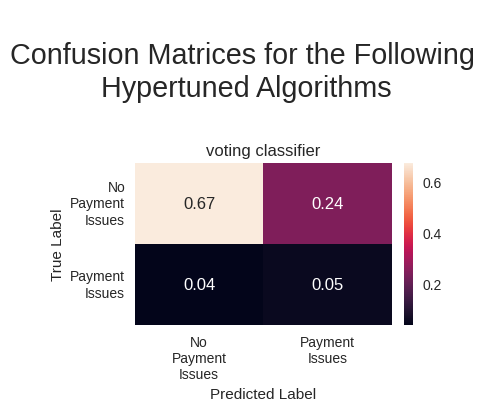

In [ ]:
%reload_ext autoreload

dfunc.plot_confusion_matrices(vot_prob, y_test,
                              names = ['voting classifier'],
                              n_cols = 1, normalize = 'all',
                              threshold = 0.5, labels = labels,
                              title = 'for the Following \nHypertuned Algorithms')

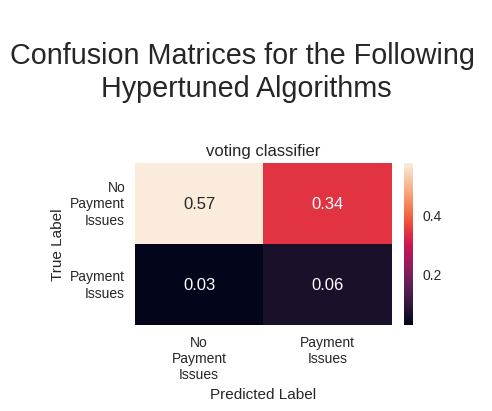

In [ ]:
%reload_ext autoreload

dfunc.plot_confusion_matrices(vot_prob, y_test,
                              names = ['voting classifier'],
                              n_cols = 1, normalize = 'all',
                              threshold = 0.42, labels = labels,
                              title = 'for the Following \nHypertuned Algorithms')

### Summary

Results (CM and balanced accuracy and ROC AUC scores) are worse than LightGBM alone.

### Bagging Logistic Regression

In [ ]:
%%time
%reload_ext autoreload

# XGBoost issues with fit_params again...

clf_name = 'Logistic Regression'
clf = classifier_map_h[clf_name]

index = classifiers_h.index(clf_name)
fit_params = fit_params_hyped[index]

bag_name = 'bag_'+clf_name.replace(' ', '_')
bag_clas = BaggingClassifier(base_estimator=clf,random_state=0,n_estimators=100)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append((bag_name , bag_clas))
bag_pipe = Pipeline(pipe_steps)

bag_perf, bag_results, bag_prob = dfunc.model_scores(X_train, y_train, X_test,
                                                     models = [bag_pipe],
                                                     model_names = [bag_name],
                                                     cv = cvRSK)


Executing bag_Logistic_Regression
Done!
CPU times: user 5min 39s, sys: 1min 47s, total: 7min 26s
Wall time: 8min


Crossvalidation test (mean of the k-folds) scores:

In [ ]:
bag_perf.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
bag_Logistic_Regression,0.688,0.01,0.677,0.02,0.27,0.014,0.688,0.01,0.536,0.01,0.756,0.008,0.17,0.009,0.688,0.01,0.563,0.007,0.887,0.005,0.222,0.021,0.663,0.041,0.688,0.01,0.677,0.02,0.688,0.01,0.731,0.019,0.731,0.019,0.731,0.019,0.731,0.019,0.731,0.019


Scores on Test Data:

In [ ]:
%reload_ext autoreload

bag_perf_test = dfunc.get_test_scores_binary(y_test, bag_prob, model_names = [bag_name])
bag_perf_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
bag_Logistic_Regression,0.677,0.267,0.166,0.678,0.748


##### Confusion Matrix

CPU times: user 266 ms, sys: 125 ms, total: 391 ms
Wall time: 274 ms


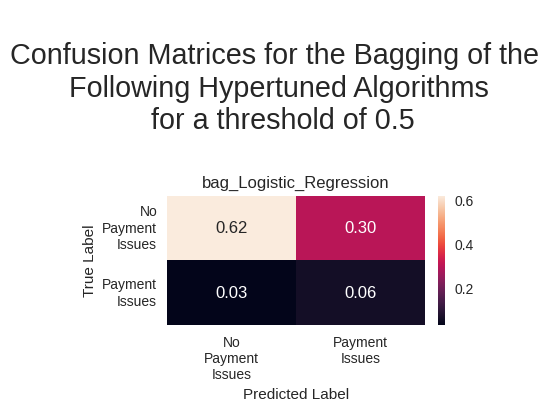

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.5
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob, y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

CPU times: user 255 ms, sys: 145 ms, total: 399 ms
Wall time: 276 ms


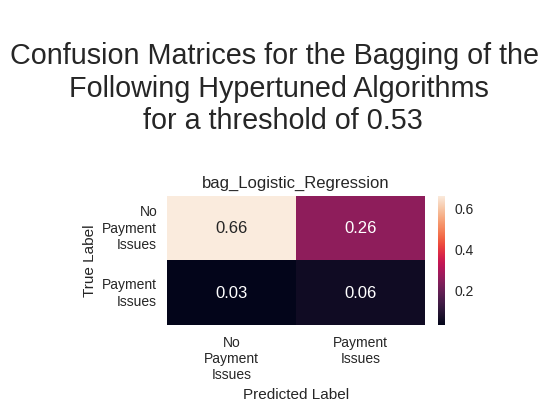

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.53
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob, y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

### Summary

With slightly shifting the threshold, we improve the results. This here seems to be the best model of this study

### Bagging LightGBM

In [ ]:
%%time
%reload_ext autoreload

# XGBoost issues with fit_params again...

LGBMClas_bag = LGBMClassifier(class_weight ='balanced', verbosity=-100)
LGBMClas_bag_params = param_classifiers['LightGBM'].copy()
LGBMClas_bag_params.pop('early_stopping_round')
LGBMClas_bag.set_params(**LGBMClas_bag_params)

clf_name = 'LightGBM'
clf = LGBMClas_bag

index = classifiers_h.index(clf_name)
fit_params = fit_params_hyped[index]

bag_name_lgb = 'bag_'+clf_name.replace(' ', '_')
bag_clas = BaggingClassifier(base_estimator=clf,random_state=0,n_estimators=100)

pipe_steps = pipe_prep_steps_tree.copy()    # preprocessor for tree algorithms
pipe_steps.append((bag_name_lgb, bag_clas))
bag_pipe_lgb = Pipeline(pipe_steps)

bag_perf_lgb, bag_results_lgb, bag_prob_lgb = dfunc.model_scores(X_train, y_train, X_test,
                                                     models = [bag_pipe_lgb],
                                                     model_names = [bag_name_lgb],
                                                     cv = cvRSK)


Executing bag_LightGBM
Done!
CPU times: user 13min 28s, sys: 1min 25s, total: 14min 54s
Wall time: 14min 13s


Crossvalidation test (mean of the k-folds) scores:

In [ ]:
bag_perf_lgb.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
bag_LightGBM,0.767,0.009,0.657,0.02,0.281,0.019,0.767,0.009,0.571,0.011,0.811,0.006,0.192,0.013,0.767,0.009,0.569,0.008,0.88,0.005,0.223,0.021,0.523,0.039,0.767,0.009,0.657,0.02,0.767,0.009,0.731,0.02,0.731,0.02,0.731,0.02,0.731,0.02,0.731,0.02


Scores on Test Data:

In [ ]:
%reload_ext autoreload

bag_perf_lgb_test = dfunc.get_test_scores_binary(y_test, bag_prob_lgb, model_names = [bag_name_lgb])
bag_perf_lgb_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
bag_LightGBM,0.68,0.296,0.198,0.586,0.755


##### Confusion Matrix

CPU times: user 290 ms, sys: 83.9 ms, total: 374 ms
Wall time: 340 ms


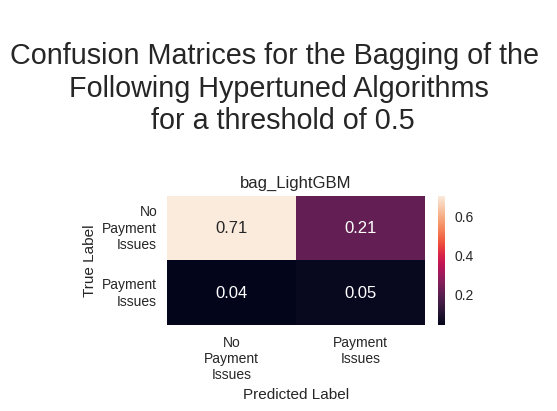

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.5
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob_lgb, y_test,
                              names = [bag_name_lgb],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

CPU times: user 322 ms, sys: 131 ms, total: 453 ms
Wall time: 465 ms


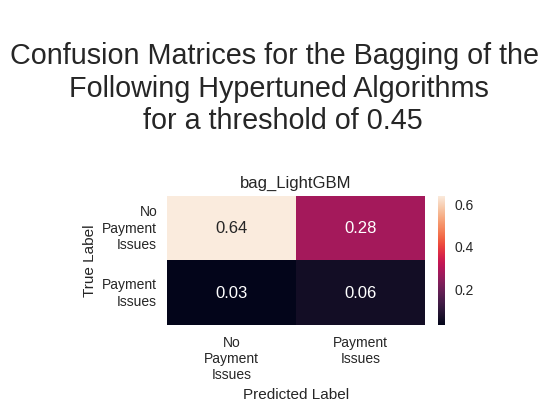

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.45
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

dfunc.plot_confusion_matrices(bag_prob_lgb, y_test,
                              names = [bag_name_lgb],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

#### Summary

Results (CM and balanced accuracy and ROC AUC scores) are worse than LightGBM alone. than for the bagged Logistic Regression.

## ROCAUC, Precisions-Recall curve and Discrimination Threshold

### ROC AUC

ROC AUC curve for bagged LightGBM model:

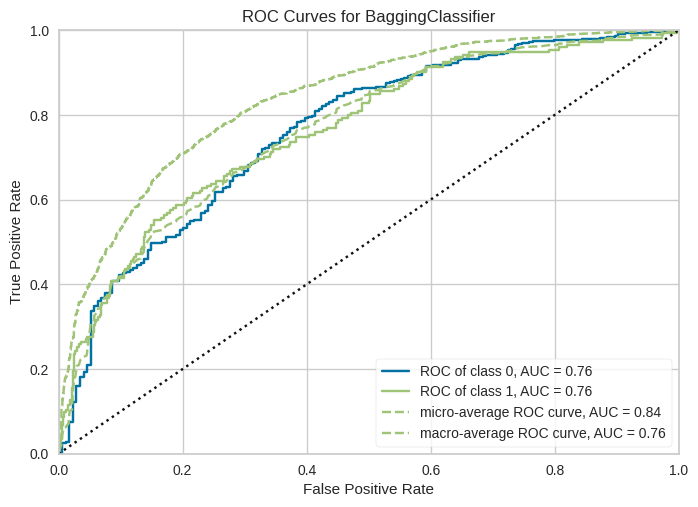

CPU times: user 20.8 s, sys: 2.62 s, total: 23.4 s
Wall time: 22.5 s


<Axes: title={'center': 'ROC Curves for BaggingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
%%time

model_pipe = bag_pipe_lgb
#model_pipe = pipe

model_pipe.fit(X_train, y_train)

visualizer = ROCAUC(model_pipe, classes= LE.classes_)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();

ROC AUC curve for bagged Logistic Regression model:

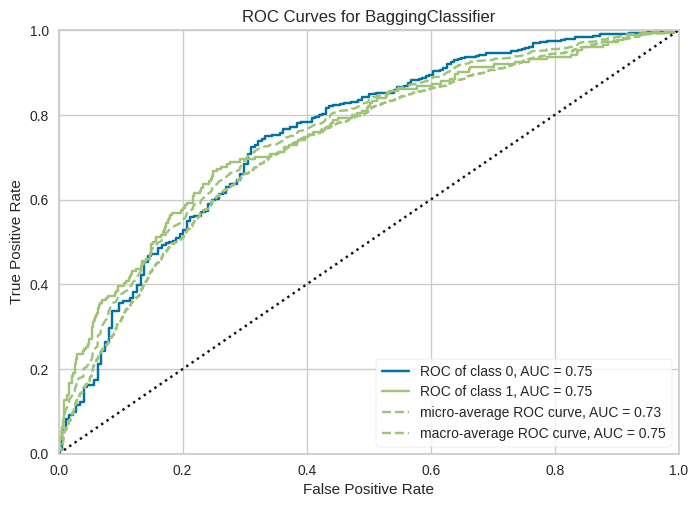

In [ ]:
model_pipe = bag_pipe
#model_pipe = pipe

model_pipe.fit(X_train, y_train)

visualizer = ROCAUC(model_pipe, classes= LE.classes_)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();

### Precision Recall Curve

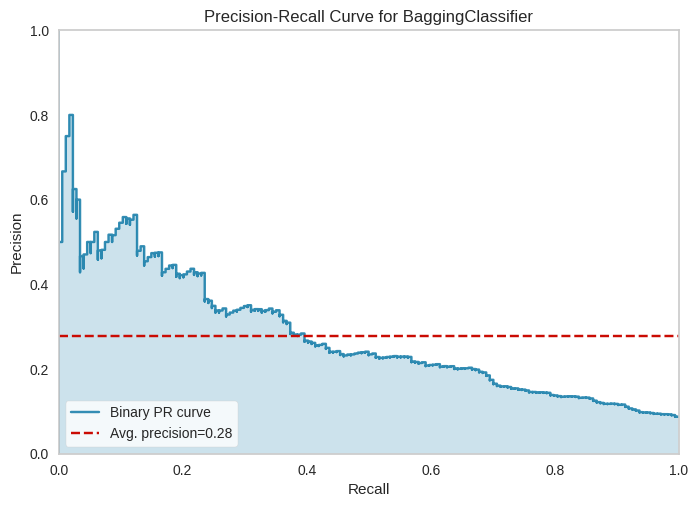

CPU times: user 2.69 s, sys: 1.16 s, total: 3.84 s
Wall time: 2.8 s


<Axes: title={'center': 'Precision-Recall Curve for BaggingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
%%time

viz = PrecisionRecallCurve(model_pipe, classes= LE.classes_)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

### Discrimination Threshold

Maybe the yellowbrick-module can find us a useful decision threshold:

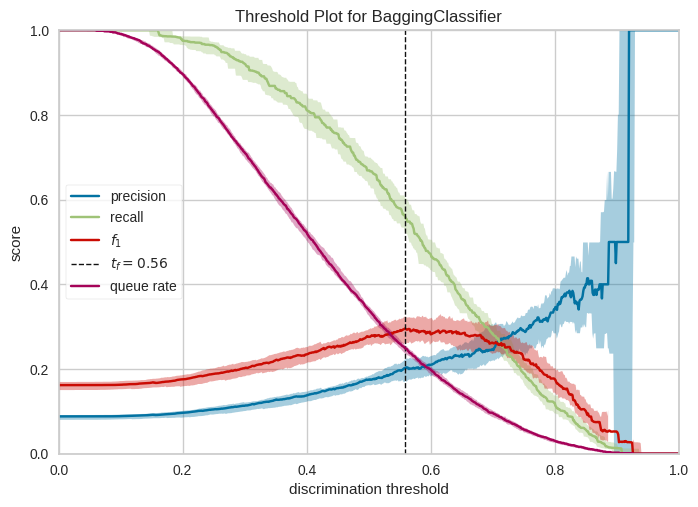

CPU times: user 4min 34s, sys: 1min 15s, total: 5min 49s
Wall time: 6min 47s


<Axes: title={'center': 'Threshold Plot for BaggingClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [ ]:
%%time
# does not finish for bagged lgb...
# not supported for multiclass
visualizer = DiscriminationThreshold(model_pipe, quantiles=np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show();

In [ ]:
%%time

# needs results from DiscriminationThreshold - not supported for multiclass

best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()].round(3)
print('best_threshold:', best_threshold.round(3))
thresh_pipe = Thresholder(model_pipe, best_threshold, refit=False)

thresh_pipe.fit(X_train, y_train)

best_threshold: 0.559
CPU times: user 522 µs, sys: 0 ns, total: 522 µs
Wall time: 486 µs


Thresholder(model=Pipeline(steps=[('preprocessor',
                                   ColumnTransformer(remainder='passthrough',
                                                     sparse_threshold=0,
                                                     transformers=[('num',
                                                                    Pipeline(steps=[('imputer',
                                                                                     KNNImputer(n_neighbors=3)),
                                                                                    ('scaler',
                                                                                     StandardScaler())]),
                                                                    ['SELLERPLACE_AREA',
                                                                     'AMT_ANNUITY_CREDIT_ratio_prev',
                                                                     'int_rate_plain_diff',
                                                                     'int_rate_plain',
                                                                     'DAYS_LAST_DUE_1ST_VERSION',
                                                                     'DAYS_FIRST_DUE...
                                                                     'AMT_CREDIT_DEBT_LIMIT_RATIO',
                                                                     'AMT_GOODS_PRICE_CREDIT_ratio_prev']),
                                                                   ('cat',
                                                                    Pipeline(steps=[('encoder',
                                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                                    [])])),
                                  ('bag_Logistic_Regression',
                                   BaggingClassifier(base_estimator=LogisticRegression(C=0.0169909501075286,
                                                                                       class_weight='balanced',
                                                                                       n_jobs=-1,
                                                                                       random_state=1),
                                                     n_estimators=100,
                                                     random_state=0))]),
            threshold=0.559)

#### Confusion Matrix

CPU times: user 1.51 s, sys: 715 ms, total: 2.22 s
Wall time: 1.62 s


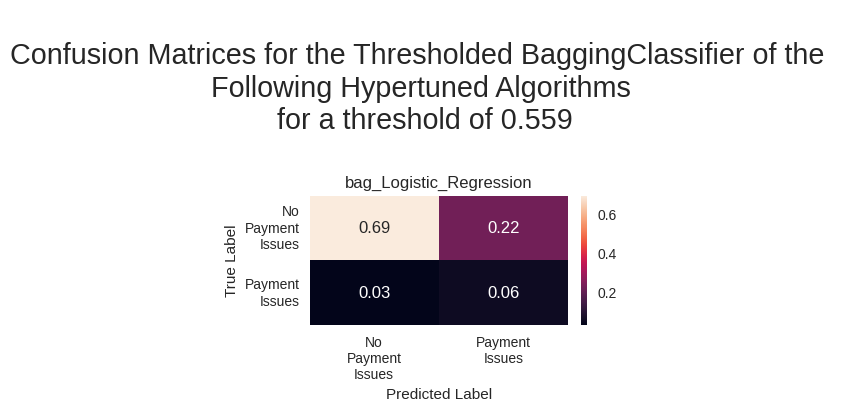

In [ ]:
%%time
%reload_ext autoreload

thresh = 0.51
title = 'for the Thresholded BaggingClassifier of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(best_threshold)


thresh_prob = thresh_pipe.predict_proba(X_test)

dfunc.plot_confusion_matrices([thresh_prob], y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = best_threshold, labels = labels,
                              title = title)

#### Summary

Having the yellowbrick algorithm shift the theshold in improves the situation for the TN and FP by 0.1 - 0.2, but the FN has increase by 0.02. It depend on the amount of money lost in these +0.02 on the FN compared to the interest won by the -0.2 on the FP, whether this model and threshold are favorable over the bagged Logistic Regression with a mild threshold shift of < 0.05.

## Explainability

Which are the main predictors per model?

### Permutation Importance

In [ ]:
%%time

X_test_transformed = pd.DataFrame(bag_pipe[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(bag_pipe[-1],
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

CPU times: user 5.12 s, sys: 3.95 s, total: 9.07 s
Wall time: 6.11 s


Weight,Feature
0.0250 ± 0.0083,num__EXT_SOURCE_3
0.0117 ± 0.0050,num__EXT_SOURCE_2
0.0091 ± 0.0102,num__EXT_SOURCE_1
0.0082 ± 0.0087,num__AMT_GOODS_PRICE
0.0054 ± 0.0047,num__DAYS_FIRST_DUE
0.0046 ± 0.0076,num__DAYS_LAST_DUE_1ST_VERSION
0.0039 ± 0.0069,num__AMT_ANNUITY_CREDIT_ratio
0.0029 ± 0.0016,num__AMT_ANNUITY_CREDIT_ratio_prev
0.0019 ± 0.0084,num__int_rate_plain
0.0019 ± 0.0015,num__SELLERPLACE_AREA


In [ ]:
%%time

X_test_transformed = pd.DataFrame(bag_pipe_lgb[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(bag_pipe_lgb[-1],
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

CPU times: user 58.2 s, sys: 1.02 s, total: 59.2 s
Wall time: 59.7 s


Weight,Feature
0.0096 ± 0.0117,num__EXT_SOURCE_3
0.0007 ± 0.0010,num__SELLERPLACE_AREA
0.0000 ± 0.0033,num__HOUR_APPR_PROCESS_START_prev
-0.0001 ± 0.0072,num__TERM_ACTUAL_months
-0.0004 ± 0.0127,num__EXT_SOURCE_2
-0.0006 ± 0.0033,num__DAYS_LAST_DUE_1ST_VERSION
-0.0012 ± 0.0029,num__int_rate_plain_diff
-0.0016 ± 0.0035,num__AMT_ANNUITY_CREDIT_ratio_prev
-0.0024 ± 0.0069,num__AMT_ANNUITY_CREDIT_ratio
-0.0028 ± 0.0056,num__AMT_CREDIT_DEBT_LIMIT_RATIO


In [ ]:
%%time
%reload_ext autoreload

clf_name = 'LightGBM'
index = classifiers_h.index(clf_name)
pipe = models_hyped[index]

model_pipe = pipe
model_pipe.fit(X_train, y_train)
X_test_transformed = pd.DataFrame(model_pipe[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(model_pipe[-1], scoring=scoring,
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

CPU times: user 7.9 s, sys: 1.83 s, total: 9.73 s
Wall time: 9.08 s


Weight,Feature
0.0752 ± 0.0287,num__EXT_SOURCE_3
0.0234 ± 0.0216,num__EXT_SOURCE_2
0.0199 ± 0.0090,num__EXT_SOURCE_1
0.0122 ± 0.0134,num__int_rate_plain
0.0091 ± 0.0079,num__AMT_CREDIT_DEBT_LIMIT_RATIO
0.0058 ± 0.0079,num__AMT_GOODS_PRICE_CREDIT_ratio_prev
0.0056 ± 0.0062,num__DAYS_FIRST_DUE
0.0055 ± 0.0055,num__int_rate_plain_diff
0.0042 ± 0.0064,num__DAYS_LAST_DUE_1ST_VERSION
0.0040 ± 0.0097,num__AMT_ANNUITY_CREDIT_ratio


### SHAP evaluation

#### Bagging Logistic Regression

In [ ]:
%%time

# cannot work on BaggedClassifier as whole - pick one out of the bag

pipe = bag_pipe

model_pipe = pipe
model_pipe.fit(X_train, y_train)

X_test_transformed = np.array(model_pipe[:-1].transform(X_test))
X_train_transformed = np.array(model_pipe[:-1].fit_transform(X_train))

explainer = shap.Explainer(bag_clas[0], X_train_transformed,
                           feature_names=new_cols, )
shap_values = explainer(X_test_transformed) #, check_additivity=False)


CPU times: user 14.5 s, sys: 3.06 s, total: 17.5 s
Wall time: 18.1 s


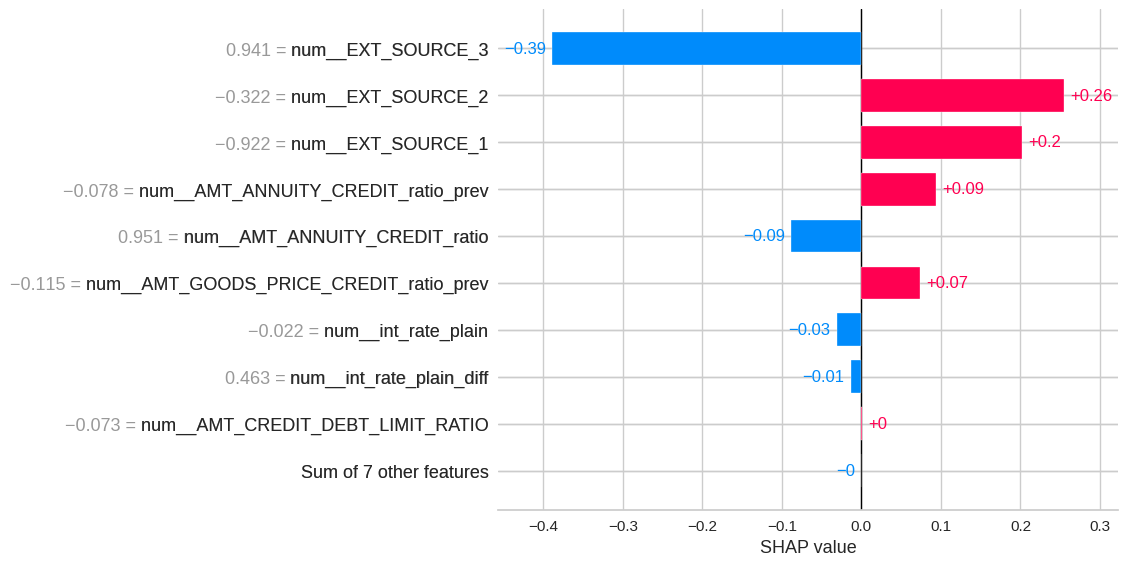

In [ ]:
shap.initjs()
shap.plots.bar(shap_values[0])

#### Logistic Regression

In [ ]:
%%time

clf_name = 'Logistic Regression'
index = classifiers_h.index(clf_name)
pipe = models_hyped[index]

model_pipe = pipe
model_pipe.fit(X_train, y_train)

X_test_transformed = np.array(model_pipe[:-1].transform(X_test))
X_train_transformed = np.array(model_pipe[:-1].fit_transform(X_train))

explainer = shap.Explainer(model_pipe[-1], X_train_transformed,
                           feature_names=new_cols, )
shap_values = explainer(X_test_transformed) #, check_additivity=False)


CPU times: user 11.8 s, sys: 2.96 s, total: 14.8 s
Wall time: 13.6 s


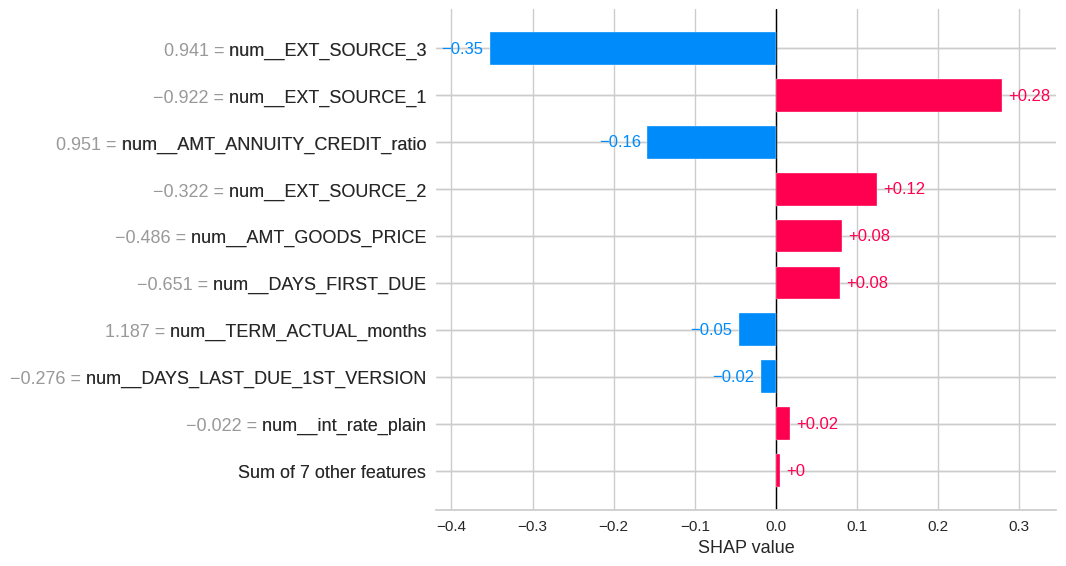

In [ ]:
shap.initjs()
shap.plots.bar(shap_values[0])

#### Bagging LightGBM

In [ ]:
%%time

# does not work for LightGBM, XGBoost (wrappers?), KNN
# drop early stopping parameter (used in .fit())

LGBMClas_shap = LGBMClassifier(class_weight ='balanced', verbosity=-100)
LGBMClas_shap_params = param_classifiers['LightGBM'].copy()
LGBMClas_shap_params.pop('early_stopping_round')
LGBMClas_shap.set_params(**LGBMClas_shap_params)

clf_name = 'LightGBM'
clf = LGBMClas_shap

pipe_steps = pipe_prep_steps_tree.copy()    # preprocessor for tree algorithms
pipe_steps.append((clf_name, clf))
shap_pipe = Pipeline(pipe_steps)

model_pipe = shap_pipe
model_pipe.fit(X_train, y_train)

X_test_transformed = np.array(model_pipe[:-1].transform(X_test))
X_train_transformed = np.array(model_pipe[:-1].fit_transform(X_train))

explainer = shap.Explainer(model_pipe[-1], X_train_transformed,
                           feature_names=new_cols, )
shap_values = explainer(X_test_transformed) #, check_additivity=False)


CPU times: user 14.7 s, sys: 3.24 s, total: 18 s
Wall time: 16.2 s


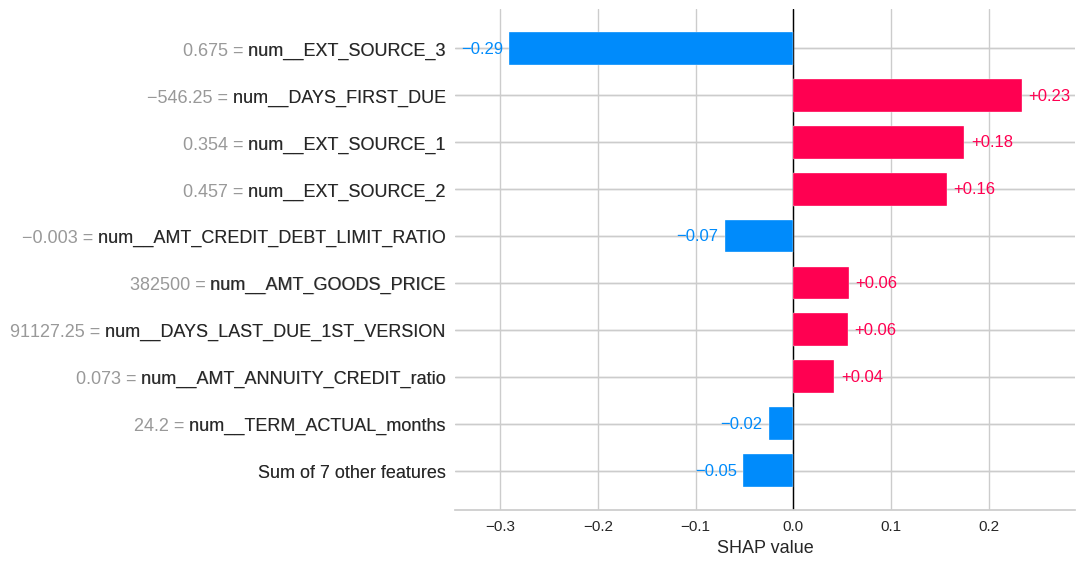

In [ ]:
shap.initjs()
shap.plots.bar(shap_values[0])

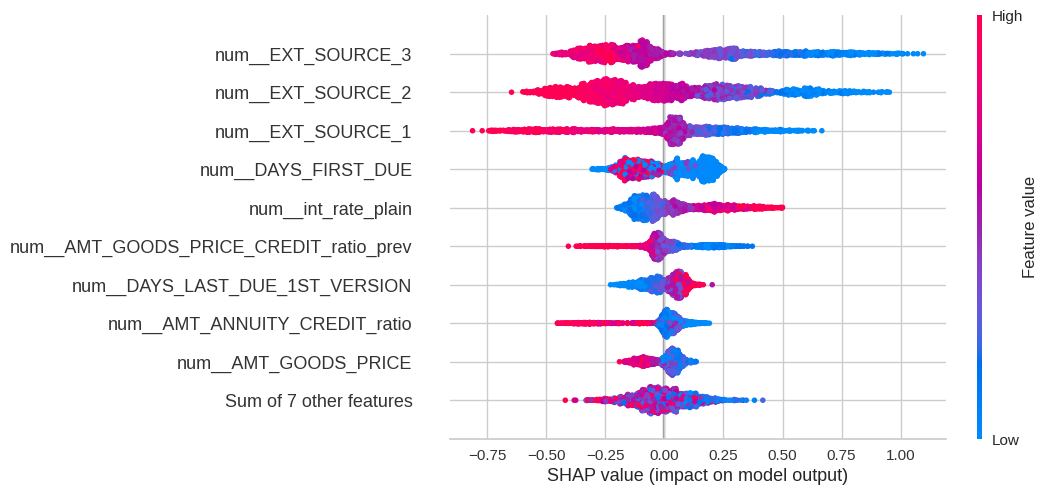

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.initjs()

shap.plots.force(shap_values[1])

In [ ]:
clustering = shap.utils.hclust(X_test_transformed, y_test)

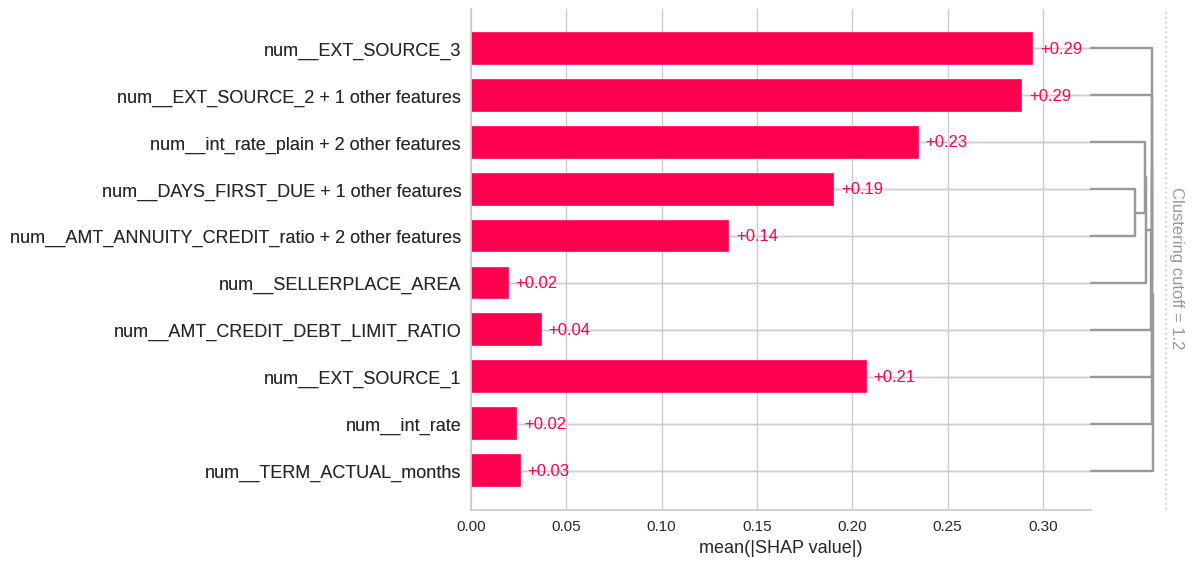

In [ ]:
shap.plots.bar(shap_values, clustering = clustering, clustering_cutoff = 1.2)

### LightGBM Feature Importances

In [ ]:
importance = np.abs(LGBMClas_shap.feature_importances_)

lgb_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
lgb_df.reset_index(inplace=True)
lgb_df = lgb_df.sort_values(by='Importance',ascending=False)

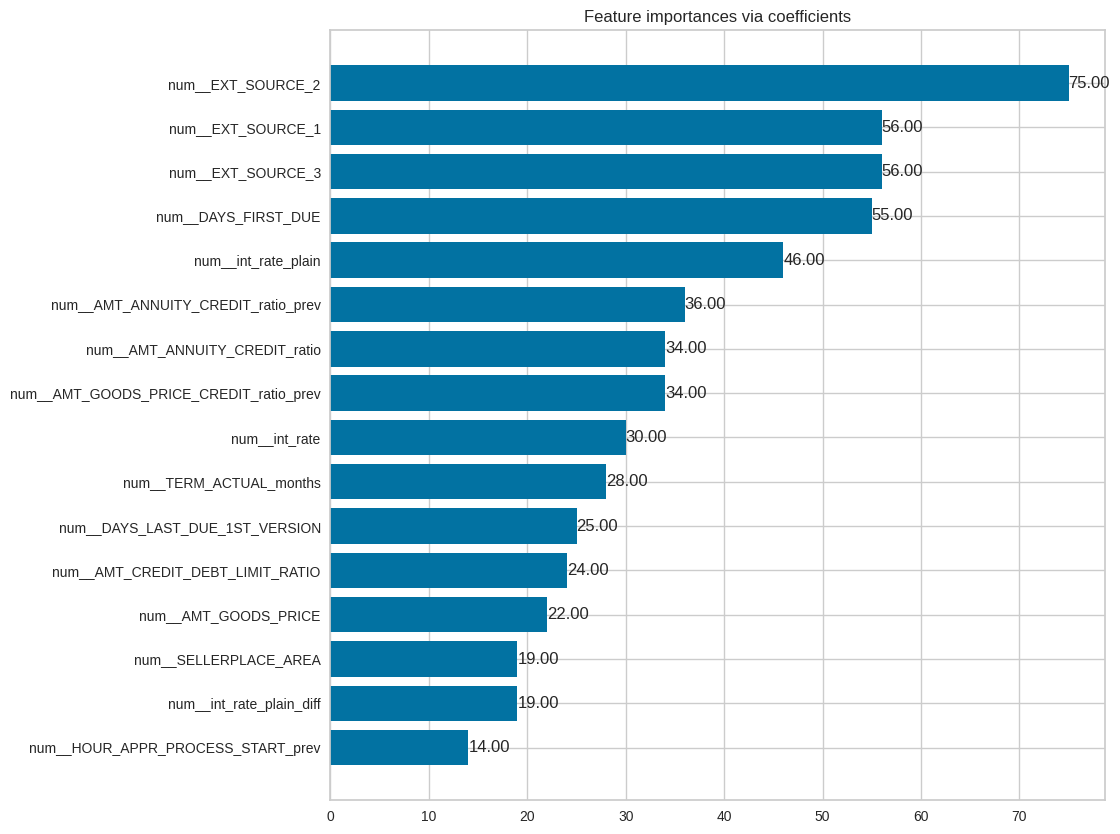

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

limit = min(20, len(lgb_df))

hbars = ax.barh(lgb_df['index'][:limit], lgb_df['Importance'][:limit], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()

#### Summary

Many of the high rank predictors match the expectations from the correlation studies in the EDA, especially EXT_SOURCE_1/2/3, which show the highest correlation with the target.

## Final Model

To be conservative, I focus on low FN and choose the model accordingly. Bagged Logistic Regression and bagged LGBM perform similarily well, the first slightly better.

Currently, the app (deployent) cannot handle LightGBM inside the sklearn routine (missing information in pickle file -> model.predict_proba(X) lead to "'Booster' object has no attribute 'handle'", i.e. it calls lgb-native functions instead of sklearn).

We have to continue with bagged logistic regression for now, anyways.

In [ ]:
final_model = bag_pipe

In [ ]:
final_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SELLERPLACE_AREA',
                                                   'AMT_ANNUITY_CREDIT_ratio_prev',
                                                   'int_rate_plain_diff',
                                                   'int_rate_plain',
                                                   'DAYS_LAST_DUE_1ST_VERSION',
                                                   'DAYS_FIRST_DUE',
                                                   'EXT_SOURCE_1',
                                                   '...
                                                   'AMT_ANNUITY_CREDIT_ratio',
                                                   'int_rate',
                                                   'AMT_CREDIT_DEBT_LIMIT_RATIO',
                                                   'AMT_GOODS_PRICE_CREDIT_ratio_prev']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('bag_Logistic_Regression',
                 BaggingClassifier(base_estimator=LogisticRegression(C=0.0169909501075286,
                                                                     class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=1),
                                   n_estimators=100, random_state=0))])

In [ ]:
filename = home_folder+'defaultrisk_model_all_tables.pickle'
pickle.dump(final_model,open(filename, 'wb'))

In [ ]:
bag_perf_test.round(3)

,balanced accuracy,f1,precision,recall,roc auc
bag_Logistic_Regression,0.677,0.267,0.166,0.678,0.748


### Test Inputs for deployed App

In [ ]:
X_test[1:2]

,SELLERPLACE_AREA,AMT_ANNUITY_CREDIT_ratio_prev,int_rate_plain_diff,int_rate_plain,DAYS_LAST_DUE_1ST_VERSION,DAYS_FIRST_DUE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START_prev,TERM_ACTUAL_months,AMT_ANNUITY_CREDIT_ratio,int_rate,AMT_CREDIT_DEBT_LIMIT_RATIO,AMT_GOODS_PRICE_CREDIT_ratio_prev
10027,44.6,0.141054,NaN,0.222059,120919.333333,-1761.333333,0.608876,0.586426,0.474051,360000.0,14.0,14.8375,0.046916,NaN,NaN,1.063893


In [ ]:
final_model.predict_proba(X_test[1:2])

array([[0.63780698, 0.36219302]])

Google Cloud deployment:

> curl -X 'POST' \
  'https://payment-issue-all-tables-xrnowswa4a-oe.a.run.app/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
  "AMT_ANNUITY_CREDIT_ratio": 0.044281,
  "AMT_ANNUITY_CREDIT_ratio_prev": 0.1317,
  "AMT_CREDIT_DEBT_LIMIT_RATIO": 0,
  "AMT_GOODS_PRICE": 472500.0,
  "AMT_GOODS_PRICE_CREDIT_ratio_prev": 1.020158,
  "DAYS_FIRST_DUE": -1805.8,
  "DAYS_LAST_DUE_1ST_VERSION": 71782,
  "EXT_SOURCE_1": 0,
  "EXT_SOURCE_2": 0.687929,
  "EXT_SOURCE_3": 0.524496,
  "HOUR_APPR_PROCESS_START_prev": 13.75,
  "SELLERPLACE_AREA": 102.917,
  "TERM_ACTUAL_months": 10.6,
  "int_rate": 1.245642,
  "int_rate_plain": 0.23047,
  "int_rate_plain_diff": 0
}'

In [ ]:
#import onnxruntime as rt
#from skl2onnx import convert_sklearn, update_registered_converter
#from skl2onnx.common.shape_calculator import (
#    calculate_linear_classifier_output_shapes,
#)  # noqa
#from onnxmltools.convert.lightgbm.operator_converters.LightGbm import (
#    convert_lightgbm,
#)  # noqa
#from skl2onnx.common.data_types import FloatTensorType

# Summary

In this case study, I have determined a model to predict the payment ability of a costomer given that he/she has records in all provided tables. In this way, I wanted to investigate which features from table other then the application table are relevant.

We have to keep in mind that this selection could mean a bias, i.e. I selected people that request loans frequently enough to appear in all tables - they might be more prone to payment issues as the value-counts in the split-test-train-section suggest.

As final estimator I chose the bagged  Logistic Regression (hypertuned on balanced accuracy).

For the dummy estimator, we obtained a CV-balanced accuracy = 0.5 and CV-ROCAUC = 0.5, while the selected estimator achieves even a
balanced accuracy = 0.678 and ROCAUC = 0.732 on the test data.

# Improvements

**General**

Feature selection/Cleaning
* software, e.g. Boruta


Models and Optimization
* try other model, e.g. CatBoost

.

**Model-specific**

Logistic Regression
* clip outliers


